In [10]:
%matplotlib notebook
import os
import numpy as np
import sys
import json
import pickle
import h5py
# import skbio
import time
import pandas as pd
import torch
import edlib

import evaluate_v2
import seaborn as sns 
import matplotlib.pyplot as plt
from data_preprocess import DNA_SEGMENT_LENGTH, SEQUENCING_ERROR_RATE
from train import align_accuracy
from argparse import ArgumentParser
from spoa import poa
from tqdm import tqdm
from Levenshtein import distance
from p_tqdm import p_map
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

In [6]:
dataset_dict = {
    'illumina': './dataset_illumina.hdf5',
}

In [7]:
model_dict = {
    'illumina': {
        'v2': { 
            "all": './model/Illumina.pth',
        }
    }
}

In [4]:
gpu = 4
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [5]:
def plot_msa_heatmap(msa):
    """
    Plots a heatmap of a multiple sequence alignment (MSA).

    Parameters:
    ----------
    msa : List[str]
        A list of aligned sequences containing only 'A', 'C', 'G', 'T', and '-'.
        All strings must be of equal length.
    """
    if not msa:
        raise ValueError("MSA input is empty.")

    # Validate input consistency
    seq_length = len(msa[0])
    if any(len(seq) != seq_length for seq in msa):
        raise ValueError("All sequences in MSA must have the same length.")

    # Map characters to integers
    base_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3, '-': 4}
    int_to_base = ['A', 'C', 'G', 'T', '-']

    # Convert to numeric matrix
    try:
        msa_matrix = np.array([[base_to_int[char] for char in row] for row in msa])
    except KeyError as e:
        raise ValueError(f"Invalid character '{e.args[0]}' in MSA. Only A, C, G, T, and '-' are allowed.")

    # Dynamically determine a readable figure size
    num_seqs = len(msa)
    num_cols = seq_length

    # Each cell should have enough pixels to be visible but not too large
    cell_width = 0.15   # width per base (x-axis)
    cell_height = 0.15  # height per sequence (y-axis)

    max_width = 30  # limit max figure width in inches
    max_height = 20 # limit max figure height in inches

    fig_width = min(max_width, cell_width * num_cols)
    fig_height = min(max_height, cell_height * num_seqs)

    # Plot heatmap
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.heatmap(msa_matrix, cmap='viridis', cbar_kws={'ticks': [0, 1, 2, 3, 4]})
    plt.title('MSA Heatmap')
    plt.xlabel('Alignment Position')
    plt.ylabel('Sequence Index')

    # Set colorbar labels
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticklabels(int_to_base)

    plt.tight_layout()
    plt.show()

In [6]:
def obtain_align_result(query, target, return_nice=False, verbose=True):
    dis = distance(query, target)
    result = edlib.align(query, target, task = "path")
    nice = edlib.getNiceAlignment(result, query, target)
    if verbose:
        print('query(up)-target(bottom)-alignment:')
        print("\n".join(nice.values()))
    
    if return_nice:
        return dis, nice
    
    return dis

In [7]:
def consensus_prob_visual(probs):
    plt.figure(figsize=(12, 4))
    sns.heatmap(probs.T, cmap="viridis", cbar=True,  # xticklabels=False, 
                yticklabels=['A', 'C', 'G', 'T'])
    plt.xlabel("Token index")
    plt.ylabel("Vocabulary index")
    plt.title("Probability distribution heatmap")
    plt.show()

In [8]:
def plot(df):
    plt.figure()
    a_df = df[['depth', 'poa']].rename(columns={'poa': 'correct ratio(%)'})
    b_df = df[['depth', 'new']].rename(columns={'new': 'correct ratio(%)'})
    c_df = df[['depth', 'bs']].rename(columns={'bs': 'correct ratio(%)'})
    a_df['method'] = 'poa'
    b_df['method'] = 'new'
    c_df['method'] = 'bs'
    merge_df = pd.concat([a_df, b_df, c_df])
    sns.barplot(data=merge_df, x='depth', y='correct ratio(%)', hue='method')
    plt.legend(loc='best', bbox_to_anchor=[1, 1])
    plt.tight_layout()

In [9]:
# def vote_consensus(msa):
#     msa = skbio.TabularMSA([skbio.DNA(s) for s in msa])
#     return str(msa.consensus()).replace('-', '')

def vote_consensus(msa):
    # Convert to NumPy array of shape (num_seqs, seq_len)
    arr = np.array([list(seq) for seq in msa])
    
    consensus = []
    for col in arr.T:  # iterate over columns
        # Count each base
        unique, counts = np.unique(col, return_counts=True)
        # Choose the one with the highest count (break ties by lexicographic order)
        consensus.append(unique[np.argmax(counts)])
    
    return ''.join(consensus).replace('-', '')

In [10]:
def bsalign_process_v2(seqs, file_dir, file_idx):
    bsalign_exe_path = './dna_storage_bench_tools/Reconstruction/bsalign/bsalign'
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    
    fasta_path = os.path.join(file_dir, f"{file_idx}.fasta")
    consensus_path = os.path.join(file_dir, f"{file_idx}.consensus")
    alignment_path = os.path.join(file_dir, f"{file_idx}.alignment")

    with open(fasta_path, 'w') as test_f:
        for s_id, s in enumerate(seqs):
            test_f.write(f'>{s_id}\n{s}\n')

    _ = os.system(
        f'{bsalign_exe_path} poa {fasta_path} -o {consensus_path} -L > {alignment_path}'
    )

    with open(alignment_path) as f:
        msa = [
            line.strip().split(' ')[3].upper().replace('.', '-')
            for line in f.readlines()[2: 2 + len(seqs)]
        ]
        
        cns = vote_consensus(msa)

    os.remove(fasta_path)
    os.remove(consensus_path)
    os.remove(alignment_path)
    return file_idx, msa, cns


def bsalign_process_parallel(data, file_dir):
    data_list = [(item['seqs'], file_dir, cluster) for (cluster, item) in data.items()]
    results = p_map(lambda kv: bsalign_process_v2(kv[0], kv[1], kv[2]), data_list, num_cpus=72)
    return dict([(k, msa) for k, msa, cns in results]), dict([(k, cns) for k, msa, cns in results])

In [11]:
def bmala_consensus_process(idx, seqs, dump_ref_len):
    _exe = './dna_storage_bench_tools/Reconstruction/BMALA/BMALA'
    _out_path = f'./dna_storage_bench_tools/bmala_out/{idx}'
    if not os.path.exists(_out_path):
        os.makedirs(_out_path)
    file_path = os.path.join(_out_path, 'test.fa')
    dump_ref = 'A' * dump_ref_len
    with open(file_path, 'w') as test_f:
        test_f.write(f'{dump_ref}\n****\n')
        for s_id, s in enumerate(seqs):
            test_f.write(f'{s}\n')
        test_f.write('\n\n')
    
    _ = os.system(
        f'{_exe} {file_path} {_out_path} > /dev/null'
    )
    
    with open(os.path.join(_out_path, 'output-results-fail.txt'), 'r') as f:
        ret = f.readlines()[2].strip()
    
    return ret, idx


def bmala_consensus_parallel(data_dict):
    args = data_dict
    
    results = p_map(lambda kv: bmala_consensus_process(kv[0], kv[1], kv[2]), args, num_cpus=72)

    return dict([(k, val) for val, k in results])


In [12]:
def itr_consensus_process(record_idx, cluster_idx, seqs, dump_ref_len):
    itr_exe = './dna_storage_bench_tools/Reconstruction/Iterative/DNA'
    itr_out_path = f'./dna_storage_bench_tools/itr_out/{record_idx}_{cluster_idx}'
    if not os.path.exists(itr_out_path):
        os.makedirs(itr_out_path)
    file_path = os.path.join(itr_out_path, 'test.fa')
    dump_ref = 'A' * dump_ref_len
    with open(file_path, 'w') as test_f:
        test_f.write(f'{dump_ref}\n****\n')
        for s_id, s in enumerate(seqs):
            test_f.write(f'{s}\n')
        test_f.write('\n\n')
    
    _ = os.system(
        f'{itr_exe} {file_path} {itr_out_path} > /dev/null'
    )
    
    with open(os.path.join(itr_out_path , 'output-results-fail.txt'), 'r') as f:
        ret = f.readlines()[2].strip()
        
    return ret, record_idx, cluster_idx


def itr_consensus_parallel(data_dict):
    args = data_dict
    
    results = p_map(lambda kv: itr_consensus_process(kv[0], kv[1], kv[2], kv[3]), args, num_cpus=72)

    return [(a, b, c) for a, b, c in results]

In [13]:
# # unified parallel algorithm 
# def unified_consensns_process(record_idx, cluster_idx, seqs, dump_ref_len, algorithm):
#     exe_db = {
#         # poa, bsalign, itr, bmala, 
#         'xx': 'path'
#     }[algorithm]
    
#     # .... 
    
#     return msa, cns, record_idx, cluster_idx  # msa can be None


# def unified_consensus_parallel(data_dict, algorithm):
    
#     # ... results 
#     return [(a,b,c,d) for a,b,c,d in results]

In [14]:
"""
bsalign 默认用 Global alignment + Vote consensus generation;
POA     默认用 Local alignment (algorithm=0), 算法接口输出的consensus和手动Vote生成的没有区别
其他算法用默认设置, ITR 算法效率最低必须多线程计算. 
"""

def test(
    sequencing_type,
    model_version,
    model_depth,
    batch_size,
    min_depth,
    max_depth,
    epochs,
    qual_vocab_size,
    context_len,
    decode_len,
    record_st=0,
    poa_method='global',
    poa_use_vote=True,
    use_bsalign=True,
    bsalign_out_dir=None,
    skip_itr=False,
):
    poa_algorithm_id = {
        'local'      : 0,
        'global'     : 1,
        'semi_global': 2,
    }[poa_method]
    
    if model_version == 'v1':
        predictor = evaluate.ConsensusPredictor(
            model_path=model_dict[sequencing_type][model_version],
            qual_vocab_size=qual_vocab_size,
            context_len=context_len,
            decode_len=decode_len,
            max_depth=max_depth,
            batch_size=batch_size,
            gpu=gpu,
        )
    else:
        predictor = evaluate_v2.ConsensusPredictor(
            model_path=model_dict[sequencing_type][model_version][model_depth],
            qual_vocab_size=qual_vocab_size,
            context_len=context_len,
#             decode_len=decode_len,
            max_depth=max_depth,
            batch_size=batch_size,
            gpu=gpu,
        )

    data = h5py.File(dataset_dict[sequencing_type])
    
    rng = np.random.default_rng(seed=42)
    total_record_indices = np.arange(len(data.keys()))
    rng.shuffle(total_record_indices) 
    valid_size = len(data.keys()) - int(len(data.keys()) * 0.75)
    valid_record_indices = total_record_indices[-valid_size:]
    print('valid_size:', valid_size)
    
    seqs  = []
    quals = []
    refs  = []
    
    for valid_idx in valid_record_indices:
        seqs.append(data[str(valid_idx)]['seqs'])
        quals.append(data[str(valid_idx)]['quals'])
        refs.append(data[str(valid_idx)]['refs'])
    
    num_records = len(seqs) 
    if epochs is not None:
        num_records = min(num_records, epochs)
     
    ret_dict = []
    for record_idx in tqdm(range(record_st, num_records)):
        batched_data = {}
        runtime_data = {}
        curr_ref = refs[record_idx][0].decode('ascii')
        # curr_len = lens[record_idx]
        for depth in range(min_depth, max_depth + 1):
            cluster_id = f"D{depth}"
            batched_data[cluster_id] = {
                'refs' : curr_ref, 
                'seqs' : [s.decode('ascii') for s in  seqs[record_idx][np.arange(depth)]], 
                'quals': [s.decode('ascii') for s in quals[record_idx][np.arange(depth)]],
            }
        
        clock_st = time.time()
        bs_msa_dict, bs_cns_dict = bsalign_process_parallel(batched_data, bsalign_out_dir)
        clock_en = time.time()
        runtime_data['bs'] = (clock_en - clock_st)
        
        clock_st = time.time()
        bmala_out = bmala_consensus_parallel([
            (cluster, item['seqs'], decode_len) 
            for cluster, item in batched_data.items()
        ])
        clock_en = time.time()
        runtime_data['bmala'] = (clock_en - clock_st)
        
        clock_st = time.time()
        if model_version == 'v1':
            output = predictor.predict(
                batched_data,
                use_bsalign=use_bsalign,
                bsalign_out_dir=bsalign_out_dir,
            )
        else:
            output = predictor.predict(
                batched_data, 
                bs_msa_dict, 
            )
        clock_en = time.time()
        runtime_data['new']   = (clock_en - clock_st)
        
        runtime_data['poa']   = 0
        for cluster in batched_data.keys():
            clock_st = time.time()
            poa_cns, poa_msa_list = poa(batched_data[cluster]['seqs'], algorithm=poa_algorithm_id)
            if poa_use_vote:
                output[cluster]['poa_consensus'] = vote_consensus(poa_msa_list)
            else:
                output[cluster]['poa_consensus'] = poa_cns
            clock_en = time.time()
            runtime_data['poa'] += (clock_en - clock_st)
            
            output[cluster]['bs_consensus']    = bs_cns_dict[cluster]
            output[cluster]['bmala_consensus'] = bmala_out[cluster]
            output[cluster]['poa_dis']   = distance(batched_data[cluster]['refs'], output[cluster]['poa_consensus'])
            output[cluster]['new_dis']   = distance(batched_data[cluster]['refs'], output[cluster]['new_consensus'])
            output[cluster]['bs_dis']    = distance(batched_data[cluster]['refs'], output[cluster]['bs_consensus'])
            output[cluster]['bmala_dis'] = distance(batched_data[cluster]['refs'], output[cluster]['bmala_consensus'])
            
        ret_dict.append((batched_data, output, runtime_data))
    
    if not skip_itr:
        _itr_process_dat = []
        for record_idx in range(len(ret_dict)):
            _batched_dat, _output, _runtime_dat = ret_dict[record_idx]
            for k, v in _batched_dat.items():
                _itr_process_dat.append(
                    (record_idx, k, v['seqs'], decode_len)
                )
        
        clock_st = time.time()
        itr_ret_dict = itr_consensus_parallel(_itr_process_dat)
        clock_en = time.time()
        itr_total_runtime = (clock_en - clock_st)
        itr_mean_runtime = itr_total_runtime / len(ret_dict)
        
        for itr_cns, record_idx, cluster_idx in itr_ret_dict:
            ret_dict[record_idx][2]['itr'] = itr_mean_runtime
            ret_dict[record_idx][1][cluster_idx]['itr_consensus'] = itr_cns
            ret_dict[record_idx][1][cluster_idx]['itr_dis'] = distance(
                ret_dict[record_idx][0][cluster_idx]['refs'],
                ret_dict[record_idx][1][cluster_idx]['itr_consensus']
            )

    return ret_dict

In [15]:
ont_ret_dict = test(
    sequencing_type='illumina',
    model_version='v2',
    model_depth='all',
    batch_size=21,
    min_depth=5,
    max_depth=20,
    record_st=0,
    epochs=None,
    qual_vocab_size=41,
    context_len=500,
    decode_len=150,
    poa_method='local',
    poa_use_vote=True,
    use_bsalign=True,
    bsalign_out_dir='illumina_bench_tmp_dir',
    skip_itr=False,
)

Load model done.
valid_size: 2410


  0%|                                                                                                                                                                                                                                                          | 0/2410 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                                                                | 1/2410 [00:03<2:29:24,  3.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                                                                                               | 2/2410 [00:07<2:38:55,  3.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                                                                               | 3/2410 [00:12<2:42:39,  4.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                                                                                                               | 4/2410 [00:16<2:45:38,  4.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                                                                                                               | 5/2410 [00:20<2:44:47,  4.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                                                                                                               | 6/2410 [00:23<2:37:22,  3.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                                                                                                               | 7/2410 [00:27<2:37:17,  3.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                                                                                                               | 8/2410 [00:32<2:43:35,  4.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▉                                                                                                                                                                                                                                               | 9/2410 [00:36<2:46:35,  4.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|▉                                                                                                                                                                                                                                              | 10/2410 [00:40<2:46:56,  4.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|█                                                                                                                                                                                                                                              | 11/2410 [00:45<2:48:00,  4.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|█▏                                                                                                                                                                                                                                             | 12/2410 [00:48<2:42:48,  4.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▎                                                                                                                                                                                                                                             | 13/2410 [00:52<2:41:50,  4.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                                                                                                             | 14/2410 [00:57<2:43:29,  4.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                                                                                                             | 15/2410 [01:01<2:47:25,  4.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                                                                                                             | 16/2410 [01:05<2:46:50,  4.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▋                                                                                                                                                                                                                                             | 17/2410 [01:09<2:43:33,  4.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▊                                                                                                                                                                                                                                             | 18/2410 [01:13<2:40:37,  4.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                                                                                                             | 19/2410 [01:17<2:40:34,  4.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                                                                                                             | 20/2410 [01:21<2:44:01,  4.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██                                                                                                                                                                                                                                             | 21/2410 [01:26<2:47:20,  4.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▏                                                                                                                                                                                                                                            | 22/2410 [01:30<2:46:40,  4.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▎                                                                                                                                                                                                                                            | 23/2410 [01:34<2:44:05,  4.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▍                                                                                                                                                                                                                                            | 24/2410 [01:38<2:41:15,  4.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▍                                                                                                                                                                                                                                            | 25/2410 [01:42<2:40:05,  4.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▌                                                                                                                                                                                                                                            | 26/2410 [01:46<2:47:27,  4.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▋                                                                                                                                                                                                                                            | 27/2410 [01:51<2:47:52,  4.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▊                                                                                                                                                                                                                                            | 28/2410 [01:55<2:50:46,  4.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▉                                                                                                                                                                                                                                            | 29/2410 [01:59<2:49:06,  4.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|██▉                                                                                                                                                                                                                                            | 30/2410 [02:03<2:42:37,  4.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███                                                                                                                                                                                                                                            | 31/2410 [02:07<2:39:10,  4.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▏                                                                                                                                                                                                                                           | 32/2410 [02:11<2:40:51,  4.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▎                                                                                                                                                                                                                                           | 33/2410 [02:15<2:42:06,  4.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▎                                                                                                                                                                                                                                           | 34/2410 [02:19<2:42:26,  4.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▍                                                                                                                                                                                                                                           | 35/2410 [02:24<2:54:22,  4.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  1%|███▌                                                                                                                                                                                                                                           | 36/2410 [02:28<2:51:50,  4.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|███▋                                                                                                                                                                                                                                           | 37/2410 [02:32<2:45:49,  4.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|███▊                                                                                                                                                                                                                                           | 38/2410 [02:37<2:47:15,  4.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|███▊                                                                                                                                                                                                                                           | 39/2410 [02:41<2:48:31,  4.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|███▉                                                                                                                                                                                                                                           | 40/2410 [02:45<2:51:04,  4.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████                                                                                                                                                                                                                                           | 41/2410 [02:50<2:53:26,  4.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▏                                                                                                                                                                                                                                          | 42/2410 [02:54<2:52:59,  4.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▎                                                                                                                                                                                                                                          | 43/2410 [02:59<2:51:11,  4.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▎                                                                                                                                                                                                                                          | 44/2410 [03:03<2:48:05,  4.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▍                                                                                                                                                                                                                                          | 45/2410 [03:07<2:43:32,  4.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▌                                                                                                                                                                                                                                          | 46/2410 [03:11<2:41:56,  4.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▋                                                                                                                                                                                                                                          | 47/2410 [03:15<2:42:38,  4.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▊                                                                                                                                                                                                                                          | 48/2410 [03:19<2:41:23,  4.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▊                                                                                                                                                                                                                                          | 49/2410 [03:23<2:42:13,  4.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|████▉                                                                                                                                                                                                                                          | 50/2410 [03:27<2:43:48,  4.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████                                                                                                                                                                                                                                          | 51/2410 [03:31<2:41:44,  4.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▏                                                                                                                                                                                                                                         | 52/2410 [03:36<2:45:00,  4.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▎                                                                                                                                                                                                                                         | 53/2410 [03:40<2:42:33,  4.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▎                                                                                                                                                                                                                                         | 54/2410 [03:44<2:42:28,  4.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▍                                                                                                                                                                                                                                         | 55/2410 [03:48<2:43:24,  4.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▌                                                                                                                                                                                                                                         | 56/2410 [03:52<2:44:41,  4.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▋                                                                                                                                                                                                                                         | 57/2410 [03:57<2:45:36,  4.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▊                                                                                                                                                                                                                                         | 58/2410 [04:01<2:45:05,  4.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▊                                                                                                                                                                                                                                         | 59/2410 [04:05<2:41:23,  4.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  2%|█████▉                                                                                                                                                                                                                                         | 60/2410 [04:09<2:40:50,  4.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████                                                                                                                                                                                                                                         | 61/2410 [04:13<2:43:21,  4.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▏                                                                                                                                                                                                                                        | 62/2410 [04:17<2:43:55,  4.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▏                                                                                                                                                                                                                                        | 63/2410 [04:21<2:42:33,  4.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▎                                                                                                                                                                                                                                        | 64/2410 [04:26<2:47:09,  4.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▍                                                                                                                                                                                                                                        | 65/2410 [04:30<2:46:16,  4.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▌                                                                                                                                                                                                                                        | 66/2410 [04:34<2:44:40,  4.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▋                                                                                                                                                                                                                                        | 67/2410 [04:38<2:40:07,  4.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▋                                                                                                                                                                                                                                        | 68/2410 [04:42<2:40:13,  4.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▊                                                                                                                                                                                                                                        | 69/2410 [04:46<2:41:44,  4.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|██████▉                                                                                                                                                                                                                                        | 70/2410 [04:50<2:40:17,  4.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████                                                                                                                                                                                                                                        | 71/2410 [04:55<2:39:42,  4.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▏                                                                                                                                                                                                                                       | 72/2410 [04:59<2:40:22,  4.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▏                                                                                                                                                                                                                                       | 73/2410 [05:03<2:45:09,  4.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▎                                                                                                                                                                                                                                       | 74/2410 [05:07<2:43:53,  4.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▍                                                                                                                                                                                                                                       | 75/2410 [05:12<2:44:24,  4.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▌                                                                                                                                                                                                                                       | 76/2410 [05:16<2:50:47,  4.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▋                                                                                                                                                                                                                                       | 77/2410 [05:21<2:49:30,  4.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▋                                                                                                                                                                                                                                       | 78/2410 [05:26<2:56:25,  4.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▊                                                                                                                                                                                                                                       | 79/2410 [05:30<2:54:27,  4.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|███████▉                                                                                                                                                                                                                                       | 80/2410 [05:34<2:52:14,  4.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|████████                                                                                                                                                                                                                                       | 81/2410 [05:38<2:47:21,  4.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|████████▏                                                                                                                                                                                                                                      | 82/2410 [05:42<2:44:22,  4.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|████████▏                                                                                                                                                                                                                                      | 83/2410 [05:47<2:46:39,  4.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  3%|████████▎                                                                                                                                                                                                                                      | 84/2410 [05:52<2:51:57,  4.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▍                                                                                                                                                                                                                                      | 85/2410 [05:56<2:50:23,  4.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▌                                                                                                                                                                                                                                      | 86/2410 [06:01<2:52:54,  4.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▋                                                                                                                                                                                                                                      | 87/2410 [06:05<2:51:10,  4.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▋                                                                                                                                                                                                                                      | 88/2410 [06:09<2:46:32,  4.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▊                                                                                                                                                                                                                                      | 89/2410 [06:13<2:46:14,  4.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|████████▉                                                                                                                                                                                                                                      | 90/2410 [06:17<2:43:17,  4.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████                                                                                                                                                                                                                                      | 91/2410 [06:22<2:45:26,  4.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████                                                                                                                                                                                                                                      | 92/2410 [06:26<2:42:21,  4.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▏                                                                                                                                                                                                                                     | 93/2410 [06:30<2:44:52,  4.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▎                                                                                                                                                                                                                                     | 94/2410 [06:34<2:45:42,  4.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▍                                                                                                                                                                                                                                     | 95/2410 [06:38<2:42:16,  4.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▌                                                                                                                                                                                                                                     | 96/2410 [06:43<2:43:09,  4.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▌                                                                                                                                                                                                                                     | 97/2410 [06:47<2:43:02,  4.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▋                                                                                                                                                                                                                                     | 98/2410 [06:51<2:41:39,  4.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▊                                                                                                                                                                                                                                     | 99/2410 [06:56<2:47:32,  4.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▉                                                                                                                                                                                                                                    | 100/2410 [07:00<2:47:26,  4.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|█████████▉                                                                                                                                                                                                                                    | 101/2410 [07:04<2:45:33,  4.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████                                                                                                                                                                                                                                    | 102/2410 [07:08<2:44:12,  4.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▏                                                                                                                                                                                                                                   | 103/2410 [07:13<2:42:05,  4.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▎                                                                                                                                                                                                                                   | 104/2410 [07:17<2:41:12,  4.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▎                                                                                                                                                                                                                                   | 105/2410 [07:21<2:44:19,  4.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▍                                                                                                                                                                                                                                   | 106/2410 [07:26<2:46:13,  4.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▌                                                                                                                                                                                                                                   | 107/2410 [07:30<2:51:43,  4.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  4%|██████████▋                                                                                                                                                                                                                                   | 108/2410 [07:35<2:51:41,  4.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|██████████▊                                                                                                                                                                                                                                   | 109/2410 [07:39<2:48:13,  4.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|██████████▊                                                                                                                                                                                                                                   | 110/2410 [07:44<2:49:30,  4.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|██████████▉                                                                                                                                                                                                                                   | 111/2410 [07:48<2:50:37,  4.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████                                                                                                                                                                                                                                   | 112/2410 [07:53<2:55:54,  4.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▏                                                                                                                                                                                                                                  | 113/2410 [08:00<3:24:27,  5.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▎                                                                                                                                                                                                                                  | 114/2410 [08:07<3:43:46,  5.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▎                                                                                                                                                                                                                                  | 115/2410 [08:15<4:03:27,  6.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▍                                                                                                                                                                                                                                  | 116/2410 [08:22<4:10:02,  6.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▌                                                                                                                                                                                                                                  | 117/2410 [08:29<4:17:54,  6.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▋                                                                                                                                                                                                                                  | 118/2410 [08:36<4:23:07,  6.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▊                                                                                                                                                                                                                                  | 119/2410 [08:43<4:19:37,  6.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▊                                                                                                                                                                                                                                  | 120/2410 [08:49<4:17:19,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|███████████▉                                                                                                                                                                                                                                  | 121/2410 [08:56<4:20:42,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████                                                                                                                                                                                                                                  | 122/2410 [09:03<4:17:43,  6.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▏                                                                                                                                                                                                                                 | 123/2410 [09:10<4:19:33,  6.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▏                                                                                                                                                                                                                                 | 124/2410 [09:17<4:25:34,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▎                                                                                                                                                                                                                                 | 125/2410 [09:25<4:29:34,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▍                                                                                                                                                                                                                                 | 126/2410 [09:32<4:31:32,  7.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▌                                                                                                                                                                                                                                 | 127/2410 [09:38<4:25:35,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▋                                                                                                                                                                                                                                 | 128/2410 [09:45<4:21:04,  6.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▋                                                                                                                                                                                                                                 | 129/2410 [09:52<4:21:04,  6.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▊                                                                                                                                                                                                                                 | 130/2410 [09:59<4:26:16,  7.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|████████████▉                                                                                                                                                                                                                                 | 131/2410 [10:07<4:30:52,  7.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  5%|█████████████                                                                                                                                                                                                                                 | 132/2410 [10:14<4:35:42,  7.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▏                                                                                                                                                                                                                                | 133/2410 [10:21<4:33:35,  7.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▏                                                                                                                                                                                                                                | 134/2410 [10:29<4:34:40,  7.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▎                                                                                                                                                                                                                                | 135/2410 [10:36<4:39:35,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▍                                                                                                                                                                                                                                | 136/2410 [10:44<4:40:28,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▌                                                                                                                                                                                                                                | 137/2410 [10:51<4:41:54,  7.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▋                                                                                                                                                                                                                                | 138/2410 [10:58<4:30:44,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▋                                                                                                                                                                                                                                | 139/2410 [11:05<4:26:48,  7.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▊                                                                                                                                                                                                                                | 140/2410 [11:11<4:23:20,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|█████████████▉                                                                                                                                                                                                                                | 141/2410 [11:18<4:23:28,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████                                                                                                                                                                                                                                | 142/2410 [11:25<4:24:26,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████                                                                                                                                                                                                                                | 143/2410 [11:33<4:28:11,  7.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▏                                                                                                                                                                                                                               | 144/2410 [11:40<4:27:20,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▎                                                                                                                                                                                                                               | 145/2410 [11:47<4:28:36,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▍                                                                                                                                                                                                                               | 146/2410 [11:54<4:32:44,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▌                                                                                                                                                                                                                               | 147/2410 [12:02<4:40:59,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▌                                                                                                                                                                                                                               | 148/2410 [12:10<4:44:14,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▋                                                                                                                                                                                                                               | 149/2410 [12:17<4:40:29,  7.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▊                                                                                                                                                                                                                               | 150/2410 [12:25<4:37:08,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|██████████████▉                                                                                                                                                                                                                               | 151/2410 [12:32<4:38:17,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████                                                                                                                                                                                                                               | 152/2410 [12:40<4:42:20,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████                                                                                                                                                                                                                               | 153/2410 [12:48<4:51:52,  7.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████▏                                                                                                                                                                                                                              | 154/2410 [12:56<4:50:57,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████▎                                                                                                                                                                                                                              | 155/2410 [13:03<4:48:50,  7.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  6%|███████████████▍                                                                                                                                                                                                                              | 156/2410 [13:10<4:40:11,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▌                                                                                                                                                                                                                              | 157/2410 [13:17<4:33:09,  7.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▌                                                                                                                                                                                                                              | 158/2410 [13:25<4:36:30,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▋                                                                                                                                                                                                                              | 159/2410 [13:32<4:34:23,  7.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▊                                                                                                                                                                                                                              | 160/2410 [13:39<4:30:56,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▉                                                                                                                                                                                                                              | 161/2410 [13:46<4:32:39,  7.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|███████████████▉                                                                                                                                                                                                                              | 162/2410 [13:54<4:32:19,  7.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████                                                                                                                                                                                                                              | 163/2410 [14:01<4:32:00,  7.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▏                                                                                                                                                                                                                             | 164/2410 [14:09<4:38:17,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▎                                                                                                                                                                                                                             | 165/2410 [14:17<4:43:58,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▍                                                                                                                                                                                                                             | 166/2410 [14:25<4:46:37,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▍                                                                                                                                                                                                                             | 167/2410 [14:32<4:40:07,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▌                                                                                                                                                                                                                             | 168/2410 [14:39<4:38:02,  7.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▋                                                                                                                                                                                                                             | 169/2410 [14:46<4:35:57,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▊                                                                                                                                                                                                                             | 170/2410 [14:53<4:30:45,  7.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▉                                                                                                                                                                                                                             | 171/2410 [15:01<4:36:19,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|████████████████▉                                                                                                                                                                                                                             | 172/2410 [15:09<4:40:57,  7.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████                                                                                                                                                                                                                             | 173/2410 [15:16<4:41:29,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▏                                                                                                                                                                                                                            | 174/2410 [15:24<4:44:00,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▎                                                                                                                                                                                                                            | 175/2410 [15:32<4:47:10,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▍                                                                                                                                                                                                                            | 176/2410 [15:39<4:41:06,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▍                                                                                                                                                                                                                            | 177/2410 [15:47<4:38:37,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▌                                                                                                                                                                                                                            | 178/2410 [15:54<4:36:21,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▋                                                                                                                                                                                                                            | 179/2410 [16:01<4:32:39,  7.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  7%|█████████████████▊                                                                                                                                                                                                                            | 180/2410 [16:09<4:41:15,  7.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|█████████████████▊                                                                                                                                                                                                                            | 181/2410 [16:17<4:43:48,  7.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|█████████████████▉                                                                                                                                                                                                                            | 182/2410 [16:24<4:42:46,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████                                                                                                                                                                                                                            | 183/2410 [16:32<4:41:05,  7.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▏                                                                                                                                                                                                                           | 184/2410 [16:39<4:36:58,  7.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▎                                                                                                                                                                                                                           | 185/2410 [16:46<4:35:00,  7.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▎                                                                                                                                                                                                                           | 186/2410 [16:54<4:33:48,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▍                                                                                                                                                                                                                           | 187/2410 [17:01<4:30:55,  7.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▌                                                                                                                                                                                                                           | 188/2410 [17:08<4:31:54,  7.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▋                                                                                                                                                                                                                           | 189/2410 [17:16<4:33:00,  7.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▊                                                                                                                                                                                                                           | 190/2410 [17:24<4:38:24,  7.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▊                                                                                                                                                                                                                           | 191/2410 [17:31<4:37:56,  7.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|██████████████████▉                                                                                                                                                                                                                           | 192/2410 [17:38<4:33:24,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████                                                                                                                                                                                                                           | 193/2410 [17:46<4:32:26,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▏                                                                                                                                                                                                                          | 194/2410 [17:54<4:39:16,  7.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▎                                                                                                                                                                                                                          | 195/2410 [18:01<4:40:21,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▎                                                                                                                                                                                                                          | 196/2410 [18:10<4:50:04,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▍                                                                                                                                                                                                                          | 197/2410 [18:18<4:52:00,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▌                                                                                                                                                                                                                          | 198/2410 [18:25<4:46:42,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▋                                                                                                                                                                                                                          | 199/2410 [18:32<4:40:04,  7.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▊                                                                                                                                                                                                                          | 200/2410 [18:39<4:32:28,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▊                                                                                                                                                                                                                          | 201/2410 [18:47<4:36:46,  7.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|███████████████████▉                                                                                                                                                                                                                          | 202/2410 [18:55<4:37:17,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|████████████████████                                                                                                                                                                                                                          | 203/2410 [19:02<4:33:24,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  8%|████████████████████▏                                                                                                                                                                                                                         | 204/2410 [19:09<4:33:50,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▏                                                                                                                                                                                                                         | 205/2410 [19:17<4:34:28,  7.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▎                                                                                                                                                                                                                         | 206/2410 [19:24<4:30:43,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▍                                                                                                                                                                                                                         | 207/2410 [19:32<4:38:15,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▌                                                                                                                                                                                                                         | 208/2410 [19:40<4:46:33,  7.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▋                                                                                                                                                                                                                         | 209/2410 [19:48<4:41:20,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▋                                                                                                                                                                                                                         | 210/2410 [19:55<4:31:27,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▊                                                                                                                                                                                                                         | 211/2410 [20:02<4:30:30,  7.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|████████████████████▉                                                                                                                                                                                                                         | 212/2410 [20:09<4:32:23,  7.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████                                                                                                                                                                                                                         | 213/2410 [20:17<4:34:54,  7.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▏                                                                                                                                                                                                                        | 214/2410 [20:26<4:45:51,  7.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▏                                                                                                                                                                                                                        | 215/2410 [20:33<4:40:17,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▎                                                                                                                                                                                                                        | 216/2410 [20:41<4:39:22,  7.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▍                                                                                                                                                                                                                        | 217/2410 [20:48<4:35:49,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▌                                                                                                                                                                                                                        | 218/2410 [20:55<4:35:07,  7.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▋                                                                                                                                                                                                                        | 219/2410 [21:03<4:35:01,  7.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▋                                                                                                                                                                                                                        | 220/2410 [21:10<4:31:12,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▊                                                                                                                                                                                                                        | 221/2410 [21:17<4:30:32,  7.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|█████████████████████▉                                                                                                                                                                                                                        | 222/2410 [21:25<4:33:16,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████                                                                                                                                                                                                                        | 223/2410 [21:32<4:28:38,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████                                                                                                                                                                                                                        | 224/2410 [21:39<4:25:59,  7.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▏                                                                                                                                                                                                                       | 225/2410 [21:47<4:31:49,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▎                                                                                                                                                                                                                       | 226/2410 [21:55<4:37:11,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▍                                                                                                                                                                                                                       | 227/2410 [22:03<4:38:26,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  9%|██████████████████████▌                                                                                                                                                                                                                       | 228/2410 [22:11<4:42:59,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|██████████████████████▌                                                                                                                                                                                                                       | 229/2410 [22:19<4:45:05,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|██████████████████████▋                                                                                                                                                                                                                       | 230/2410 [22:27<4:50:40,  8.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|██████████████████████▊                                                                                                                                                                                                                       | 231/2410 [22:35<4:51:17,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|██████████████████████▉                                                                                                                                                                                                                       | 232/2410 [22:43<4:46:21,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████                                                                                                                                                                                                                       | 233/2410 [22:51<4:43:05,  7.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████                                                                                                                                                                                                                       | 234/2410 [22:59<4:50:59,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▏                                                                                                                                                                                                                      | 235/2410 [23:06<4:43:30,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▎                                                                                                                                                                                                                      | 236/2410 [23:15<4:46:39,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▍                                                                                                                                                                                                                      | 237/2410 [23:22<4:42:29,  7.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▌                                                                                                                                                                                                                      | 238/2410 [23:30<4:40:09,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▌                                                                                                                                                                                                                      | 239/2410 [23:38<4:40:39,  7.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▋                                                                                                                                                                                                                      | 240/2410 [23:45<4:38:38,  7.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▊                                                                                                                                                                                                                      | 241/2410 [23:53<4:38:51,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▉                                                                                                                                                                                                                      | 242/2410 [24:01<4:43:56,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|███████████████████████▉                                                                                                                                                                                                                      | 243/2410 [24:09<4:43:05,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████                                                                                                                                                                                                                      | 244/2410 [24:16<4:39:39,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▏                                                                                                                                                                                                                     | 245/2410 [24:24<4:40:46,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▎                                                                                                                                                                                                                     | 246/2410 [24:32<4:38:50,  7.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▍                                                                                                                                                                                                                     | 247/2410 [24:40<4:41:55,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▍                                                                                                                                                                                                                     | 248/2410 [24:47<4:38:35,  7.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▌                                                                                                                                                                                                                     | 249/2410 [24:55<4:37:16,  7.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▋                                                                                                                                                                                                                     | 250/2410 [25:03<4:39:33,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▊                                                                                                                                                                                                                     | 251/2410 [25:10<4:35:06,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▉                                                                                                                                                                                                                     | 252/2410 [25:18<4:31:17,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|████████████████████████▉                                                                                                                                                                                                                     | 253/2410 [25:26<4:34:57,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████                                                                                                                                                                                                                     | 254/2410 [25:33<4:38:29,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▏                                                                                                                                                                                                                    | 255/2410 [25:42<4:41:40,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▎                                                                                                                                                                                                                    | 256/2410 [25:49<4:41:12,  7.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▍                                                                                                                                                                                                                    | 257/2410 [25:57<4:43:39,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▍                                                                                                                                                                                                                    | 258/2410 [26:06<4:48:50,  8.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▌                                                                                                                                                                                                                    | 259/2410 [26:14<4:50:08,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▋                                                                                                                                                                                                                    | 260/2410 [26:22<4:51:16,  8.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▊                                                                                                                                                                                                                    | 261/2410 [26:30<4:46:09,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▊                                                                                                                                                                                                                    | 262/2410 [26:38<4:50:43,  8.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|█████████████████████████▉                                                                                                                                                                                                                    | 263/2410 [26:47<4:57:11,  8.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████                                                                                                                                                                                                                    | 264/2410 [26:55<4:51:50,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▏                                                                                                                                                                                                                   | 265/2410 [27:02<4:44:56,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▎                                                                                                                                                                                                                   | 266/2410 [27:10<4:43:56,  7.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▎                                                                                                                                                                                                                   | 267/2410 [27:18<4:43:27,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▍                                                                                                                                                                                                                   | 268/2410 [27:27<4:50:56,  8.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▌                                                                                                                                                                                                                   | 269/2410 [27:36<4:56:09,  8.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▋                                                                                                                                                                                                                   | 270/2410 [27:43<4:51:46,  8.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▊                                                                                                                                                                                                                   | 271/2410 [27:51<4:49:41,  8.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▊                                                                                                                                                                                                                   | 272/2410 [28:00<4:53:45,  8.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|██████████████████████████▉                                                                                                                                                                                                                   | 273/2410 [28:08<4:49:46,  8.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|███████████████████████████                                                                                                                                                                                                                   | 274/2410 [28:16<4:47:32,  8.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|███████████████████████████▏                                                                                                                                                                                                                  | 275/2410 [28:24<4:44:46,  8.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|███████████████████████████▎                                                                                                                                                                                                                  | 276/2410 [28:32<4:47:51,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 11%|███████████████████████████▎                                                                                                                                                                                                                  | 277/2410 [28:40<4:51:16,  8.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▍                                                                                                                                                                                                                  | 278/2410 [28:48<4:45:43,  8.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▌                                                                                                                                                                                                                  | 279/2410 [28:55<4:36:36,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▋                                                                                                                                                                                                                  | 280/2410 [29:03<4:37:18,  7.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▊                                                                                                                                                                                                                  | 281/2410 [29:10<4:30:18,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▊                                                                                                                                                                                                                  | 282/2410 [29:18<4:27:25,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|███████████████████████████▉                                                                                                                                                                                                                  | 283/2410 [29:25<4:30:10,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████                                                                                                                                                                                                                  | 284/2410 [29:34<4:36:53,  7.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▏                                                                                                                                                                                                                 | 285/2410 [29:41<4:34:05,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▏                                                                                                                                                                                                                 | 286/2410 [29:49<4:31:14,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▎                                                                                                                                                                                                                 | 287/2410 [29:56<4:30:58,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▍                                                                                                                                                                                                                 | 288/2410 [30:04<4:28:03,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▌                                                                                                                                                                                                                 | 289/2410 [30:12<4:32:13,  7.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▋                                                                                                                                                                                                                 | 290/2410 [30:19<4:32:10,  7.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▋                                                                                                                                                                                                                 | 291/2410 [30:27<4:34:32,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▊                                                                                                                                                                                                                 | 292/2410 [30:36<4:47:48,  8.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|████████████████████████████▉                                                                                                                                                                                                                 | 293/2410 [30:44<4:44:25,  8.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████                                                                                                                                                                                                                 | 294/2410 [30:52<4:36:51,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▏                                                                                                                                                                                                                | 295/2410 [30:59<4:33:17,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▏                                                                                                                                                                                                                | 296/2410 [31:08<4:40:39,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▎                                                                                                                                                                                                                | 297/2410 [31:15<4:38:30,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▍                                                                                                                                                                                                                | 298/2410 [31:23<4:37:36,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▌                                                                                                                                                                                                                | 299/2410 [31:31<4:32:44,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▋                                                                                                                                                                                                                | 300/2410 [31:38<4:29:29,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 12%|█████████████████████████████▋                                                                                                                                                                                                                | 301/2410 [31:46<4:28:39,  7.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|█████████████████████████████▊                                                                                                                                                                                                                | 302/2410 [31:53<4:19:54,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|█████████████████████████████▉                                                                                                                                                                                                                | 303/2410 [31:59<4:14:03,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████                                                                                                                                                                                                                | 304/2410 [32:06<4:08:22,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████                                                                                                                                                                                                                | 305/2410 [32:13<4:07:43,  7.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▏                                                                                                                                                                                                               | 306/2410 [32:20<4:04:35,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▎                                                                                                                                                                                                               | 307/2410 [32:27<4:05:15,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▍                                                                                                                                                                                                               | 308/2410 [32:34<4:03:29,  6.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▌                                                                                                                                                                                                               | 309/2410 [32:41<4:01:22,  6.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▌                                                                                                                                                                                                               | 310/2410 [32:45<3:38:19,  6.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▋                                                                                                                                                                                                               | 311/2410 [32:51<3:32:22,  6.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▊                                                                                                                                                                                                               | 312/2410 [32:56<3:20:27,  5.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|██████████████████████████████▉                                                                                                                                                                                                               | 313/2410 [33:01<3:14:36,  5.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████                                                                                                                                                                                                               | 314/2410 [33:06<3:06:06,  5.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████                                                                                                                                                                                                               | 315/2410 [33:11<3:01:29,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▏                                                                                                                                                                                                              | 316/2410 [33:16<2:57:14,  5.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▎                                                                                                                                                                                                              | 317/2410 [33:21<3:01:14,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▍                                                                                                                                                                                                              | 318/2410 [33:26<3:00:13,  5.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▌                                                                                                                                                                                                              | 319/2410 [33:31<2:54:59,  5.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▌                                                                                                                                                                                                              | 320/2410 [33:36<2:54:31,  5.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▋                                                                                                                                                                                                              | 321/2410 [33:41<2:55:35,  5.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▊                                                                                                                                                                                                              | 322/2410 [33:46<2:59:11,  5.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▉                                                                                                                                                                                                              | 323/2410 [33:51<2:57:46,  5.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|███████████████████████████████▉                                                                                                                                                                                                              | 324/2410 [33:56<2:56:37,  5.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 13%|████████████████████████████████                                                                                                                                                                                                              | 325/2410 [34:01<2:56:29,  5.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▏                                                                                                                                                                                                             | 326/2410 [34:06<2:55:08,  5.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▎                                                                                                                                                                                                             | 327/2410 [34:11<2:54:23,  5.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▍                                                                                                                                                                                                             | 328/2410 [34:16<2:55:36,  5.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▍                                                                                                                                                                                                             | 329/2410 [34:21<2:53:26,  5.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▌                                                                                                                                                                                                             | 330/2410 [34:27<2:57:39,  5.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▋                                                                                                                                                                                                             | 331/2410 [34:32<2:56:07,  5.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▊                                                                                                                                                                                                             | 332/2410 [34:37<2:54:38,  5.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▉                                                                                                                                                                                                             | 333/2410 [34:41<2:51:45,  4.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|████████████████████████████████▉                                                                                                                                                                                                             | 334/2410 [34:46<2:51:32,  4.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████                                                                                                                                                                                                             | 335/2410 [34:51<2:51:06,  4.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▏                                                                                                                                                                                                            | 336/2410 [34:57<2:54:53,  5.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▎                                                                                                                                                                                                            | 337/2410 [35:02<2:56:54,  5.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▍                                                                                                                                                                                                            | 338/2410 [35:07<2:54:39,  5.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▍                                                                                                                                                                                                            | 339/2410 [35:12<2:53:10,  5.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▌                                                                                                                                                                                                            | 340/2410 [35:17<2:58:50,  5.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▋                                                                                                                                                                                                            | 341/2410 [35:23<2:58:50,  5.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▊                                                                                                                                                                                                            | 342/2410 [35:27<2:56:00,  5.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▊                                                                                                                                                                                                            | 343/2410 [35:33<2:59:06,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|█████████████████████████████████▉                                                                                                                                                                                                            | 344/2410 [35:38<2:56:38,  5.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████                                                                                                                                                                                                            | 345/2410 [35:42<2:49:40,  4.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████▏                                                                                                                                                                                                           | 346/2410 [35:47<2:52:19,  5.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████▎                                                                                                                                                                                                           | 347/2410 [35:53<2:55:08,  5.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████▎                                                                                                                                                                                                           | 348/2410 [35:58<2:52:47,  5.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 14%|██████████████████████████████████▍                                                                                                                                                                                                           | 349/2410 [36:03<2:55:19,  5.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▌                                                                                                                                                                                                           | 350/2410 [36:08<2:57:15,  5.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▋                                                                                                                                                                                                           | 351/2410 [36:13<2:53:19,  5.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▊                                                                                                                                                                                                           | 352/2410 [36:18<2:56:01,  5.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▊                                                                                                                                                                                                           | 353/2410 [36:24<2:58:17,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|██████████████████████████████████▉                                                                                                                                                                                                           | 354/2410 [36:29<3:01:41,  5.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████                                                                                                                                                                                                           | 355/2410 [36:34<2:58:38,  5.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▏                                                                                                                                                                                                          | 356/2410 [36:39<2:57:43,  5.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▎                                                                                                                                                                                                          | 357/2410 [36:44<2:54:27,  5.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▎                                                                                                                                                                                                          | 358/2410 [36:49<2:54:34,  5.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▍                                                                                                                                                                                                          | 359/2410 [36:55<2:56:10,  5.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▌                                                                                                                                                                                                          | 360/2410 [37:00<2:59:31,  5.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▋                                                                                                                                                                                                          | 361/2410 [37:06<3:04:08,  5.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▋                                                                                                                                                                                                          | 362/2410 [37:11<3:03:33,  5.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▊                                                                                                                                                                                                          | 363/2410 [37:16<2:58:19,  5.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|███████████████████████████████████▉                                                                                                                                                                                                          | 364/2410 [37:21<2:54:45,  5.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████                                                                                                                                                                                                          | 365/2410 [37:26<2:54:01,  5.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▏                                                                                                                                                                                                         | 366/2410 [37:31<2:54:12,  5.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▏                                                                                                                                                                                                         | 367/2410 [37:36<2:52:16,  5.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▎                                                                                                                                                                                                         | 368/2410 [37:42<2:58:36,  5.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▍                                                                                                                                                                                                         | 369/2410 [37:47<2:58:53,  5.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▌                                                                                                                                                                                                         | 370/2410 [37:52<3:00:30,  5.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▋                                                                                                                                                                                                         | 371/2410 [37:58<2:59:18,  5.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▋                                                                                                                                                                                                         | 372/2410 [38:03<2:56:26,  5.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 15%|████████████████████████████████████▊                                                                                                                                                                                                         | 373/2410 [38:08<2:54:12,  5.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|████████████████████████████████████▉                                                                                                                                                                                                         | 374/2410 [38:13<2:55:30,  5.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████                                                                                                                                                                                                         | 375/2410 [38:19<3:00:26,  5.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▏                                                                                                                                                                                                        | 376/2410 [38:24<3:04:00,  5.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▏                                                                                                                                                                                                        | 377/2410 [38:30<3:04:51,  5.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▎                                                                                                                                                                                                        | 378/2410 [38:35<2:57:39,  5.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▍                                                                                                                                                                                                        | 379/2410 [38:40<2:56:07,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▌                                                                                                                                                                                                        | 380/2410 [38:45<3:00:58,  5.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▋                                                                                                                                                                                                        | 381/2410 [38:51<3:01:25,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▋                                                                                                                                                                                                        | 382/2410 [38:56<3:03:12,  5.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▊                                                                                                                                                                                                        | 383/2410 [39:01<2:58:38,  5.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|█████████████████████████████████████▉                                                                                                                                                                                                        | 384/2410 [39:07<2:59:47,  5.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████                                                                                                                                                                                                        | 385/2410 [39:12<2:54:43,  5.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████                                                                                                                                                                                                        | 386/2410 [39:17<2:56:25,  5.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▏                                                                                                                                                                                                       | 387/2410 [39:22<2:55:45,  5.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▎                                                                                                                                                                                                       | 388/2410 [39:28<2:58:17,  5.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▍                                                                                                                                                                                                       | 389/2410 [39:33<2:58:22,  5.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▌                                                                                                                                                                                                       | 390/2410 [39:38<2:55:03,  5.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▌                                                                                                                                                                                                       | 391/2410 [39:43<2:51:58,  5.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▋                                                                                                                                                                                                       | 392/2410 [39:48<2:54:32,  5.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▊                                                                                                                                                                                                       | 393/2410 [39:54<3:01:48,  5.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|██████████████████████████████████████▉                                                                                                                                                                                                       | 394/2410 [39:59<3:00:03,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|███████████████████████████████████████                                                                                                                                                                                                       | 395/2410 [40:05<2:59:33,  5.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|███████████████████████████████████████                                                                                                                                                                                                       | 396/2410 [40:10<2:56:38,  5.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 16%|███████████████████████████████████████▏                                                                                                                                                                                                      | 397/2410 [40:15<2:55:14,  5.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▎                                                                                                                                                                                                      | 398/2410 [40:20<2:55:35,  5.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▍                                                                                                                                                                                                      | 399/2410 [40:26<3:04:11,  5.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▌                                                                                                                                                                                                      | 400/2410 [40:32<3:06:56,  5.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▌                                                                                                                                                                                                      | 401/2410 [40:37<3:02:19,  5.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▋                                                                                                                                                                                                      | 402/2410 [40:42<2:56:39,  5.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▊                                                                                                                                                                                                      | 403/2410 [40:47<2:55:03,  5.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▉                                                                                                                                                                                                      | 404/2410 [40:53<2:58:22,  5.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|███████████████████████████████████████▉                                                                                                                                                                                                      | 405/2410 [40:58<2:59:22,  5.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████                                                                                                                                                                                                      | 406/2410 [41:04<3:05:07,  5.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▏                                                                                                                                                                                                     | 407/2410 [41:09<3:01:32,  5.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▎                                                                                                                                                                                                     | 408/2410 [41:14<2:56:36,  5.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▍                                                                                                                                                                                                     | 409/2410 [41:19<2:56:17,  5.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▍                                                                                                                                                                                                     | 410/2410 [41:25<2:57:28,  5.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▌                                                                                                                                                                                                     | 411/2410 [41:30<2:57:31,  5.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▋                                                                                                                                                                                                     | 412/2410 [41:35<2:57:11,  5.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▊                                                                                                                                                                                                     | 413/2410 [41:41<2:54:01,  5.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▉                                                                                                                                                                                                     | 414/2410 [41:46<2:51:37,  5.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|████████████████████████████████████████▉                                                                                                                                                                                                     | 415/2410 [41:52<3:02:15,  5.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████                                                                                                                                                                                                     | 416/2410 [41:58<3:05:49,  5.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▏                                                                                                                                                                                                    | 417/2410 [42:03<3:04:43,  5.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▎                                                                                                                                                                                                    | 418/2410 [42:09<3:04:55,  5.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▍                                                                                                                                                                                                    | 419/2410 [42:14<2:58:34,  5.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▍                                                                                                                                                                                                    | 420/2410 [42:19<2:54:45,  5.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 17%|█████████████████████████████████████████▌                                                                                                                                                                                                    | 421/2410 [42:24<2:57:43,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|█████████████████████████████████████████▋                                                                                                                                                                                                    | 422/2410 [42:30<3:00:22,  5.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|█████████████████████████████████████████▊                                                                                                                                                                                                    | 423/2410 [42:35<2:57:19,  5.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|█████████████████████████████████████████▊                                                                                                                                                                                                    | 424/2410 [42:40<2:55:24,  5.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|█████████████████████████████████████████▉                                                                                                                                                                                                    | 425/2410 [42:45<2:55:25,  5.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████                                                                                                                                                                                                    | 426/2410 [42:51<2:58:03,  5.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▏                                                                                                                                                                                                   | 427/2410 [42:56<2:55:10,  5.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▎                                                                                                                                                                                                   | 428/2410 [43:02<3:03:32,  5.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▎                                                                                                                                                                                                   | 429/2410 [43:07<2:58:41,  5.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▍                                                                                                                                                                                                   | 430/2410 [43:13<2:56:40,  5.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▌                                                                                                                                                                                                   | 431/2410 [43:18<2:54:18,  5.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▋                                                                                                                                                                                                   | 432/2410 [43:23<2:55:26,  5.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▊                                                                                                                                                                                                   | 433/2410 [43:28<2:54:56,  5.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▊                                                                                                                                                                                                   | 434/2410 [43:35<3:03:40,  5.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|██████████████████████████████████████████▉                                                                                                                                                                                                   | 435/2410 [43:40<2:59:43,  5.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████                                                                                                                                                                                                   | 436/2410 [43:45<2:57:25,  5.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▏                                                                                                                                                                                                  | 437/2410 [43:51<3:02:51,  5.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▎                                                                                                                                                                                                  | 438/2410 [43:56<3:00:26,  5.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▎                                                                                                                                                                                                  | 439/2410 [44:02<2:58:37,  5.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▍                                                                                                                                                                                                  | 440/2410 [44:07<2:58:11,  5.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▌                                                                                                                                                                                                  | 441/2410 [44:12<2:56:04,  5.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▋                                                                                                                                                                                                  | 442/2410 [44:18<2:57:19,  5.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▋                                                                                                                                                                                                  | 443/2410 [44:23<2:56:35,  5.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▊                                                                                                                                                                                                  | 444/2410 [44:29<2:58:52,  5.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 18%|███████████████████████████████████████████▉                                                                                                                                                                                                  | 445/2410 [44:34<2:55:34,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████                                                                                                                                                                                                  | 446/2410 [44:39<2:54:55,  5.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▏                                                                                                                                                                                                 | 447/2410 [44:45<2:54:57,  5.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▏                                                                                                                                                                                                 | 448/2410 [44:50<2:58:04,  5.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▎                                                                                                                                                                                                 | 449/2410 [44:56<2:57:47,  5.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▍                                                                                                                                                                                                 | 450/2410 [45:01<2:53:29,  5.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▌                                                                                                                                                                                                 | 451/2410 [45:06<2:50:24,  5.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▋                                                                                                                                                                                                 | 452/2410 [45:11<2:52:37,  5.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▋                                                                                                                                                                                                 | 453/2410 [45:17<2:56:48,  5.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▊                                                                                                                                                                                                 | 454/2410 [45:23<3:02:10,  5.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|████████████████████████████████████████████▉                                                                                                                                                                                                 | 455/2410 [45:28<3:02:43,  5.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████                                                                                                                                                                                                 | 456/2410 [45:34<3:03:56,  5.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▏                                                                                                                                                                                                | 457/2410 [45:40<3:09:07,  5.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▏                                                                                                                                                                                                | 458/2410 [45:47<3:18:15,  6.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▎                                                                                                                                                                                                | 459/2410 [45:53<3:20:41,  6.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▍                                                                                                                                                                                                | 460/2410 [45:59<3:17:43,  6.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▌                                                                                                                                                                                                | 461/2410 [46:06<3:24:58,  6.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▌                                                                                                                                                                                                | 462/2410 [46:12<3:23:49,  6.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▋                                                                                                                                                                                                | 463/2410 [46:18<3:20:18,  6.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▊                                                                                                                                                                                                | 464/2410 [46:24<3:18:05,  6.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|█████████████████████████████████████████████▉                                                                                                                                                                                                | 465/2410 [46:30<3:14:16,  5.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|██████████████████████████████████████████████                                                                                                                                                                                                | 466/2410 [46:36<3:10:10,  5.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|██████████████████████████████████████████████                                                                                                                                                                                                | 467/2410 [46:42<3:11:16,  5.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|██████████████████████████████████████████████▏                                                                                                                                                                                               | 468/2410 [46:47<3:03:51,  5.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 19%|██████████████████████████████████████████████▎                                                                                                                                                                                               | 469/2410 [46:52<2:55:07,  5.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▍                                                                                                                                                                                               | 470/2410 [46:57<2:54:07,  5.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▌                                                                                                                                                                                               | 471/2410 [47:02<2:53:19,  5.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▌                                                                                                                                                                                               | 472/2410 [47:09<3:03:35,  5.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▋                                                                                                                                                                                               | 473/2410 [47:14<3:01:56,  5.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▊                                                                                                                                                                                               | 474/2410 [47:20<3:04:02,  5.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|██████████████████████████████████████████████▉                                                                                                                                                                                               | 475/2410 [47:26<3:03:44,  5.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████                                                                                                                                                                                               | 476/2410 [47:31<3:05:02,  5.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████                                                                                                                                                                                               | 477/2410 [47:37<3:04:08,  5.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▏                                                                                                                                                                                              | 478/2410 [47:43<3:02:07,  5.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▎                                                                                                                                                                                              | 479/2410 [47:48<2:57:39,  5.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▍                                                                                                                                                                                              | 480/2410 [47:53<2:54:33,  5.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▌                                                                                                                                                                                              | 481/2410 [47:59<2:58:46,  5.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▌                                                                                                                                                                                              | 482/2410 [48:06<3:11:05,  5.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▋                                                                                                                                                                                              | 483/2410 [48:13<3:20:18,  6.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▊                                                                                                                                                                                              | 484/2410 [48:19<3:20:06,  6.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▉                                                                                                                                                                                              | 485/2410 [48:24<3:12:26,  6.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|███████████████████████████████████████████████▉                                                                                                                                                                                              | 486/2410 [48:30<3:07:27,  5.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████                                                                                                                                                                                              | 487/2410 [48:35<3:00:20,  5.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▏                                                                                                                                                                                             | 488/2410 [48:40<2:57:11,  5.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▎                                                                                                                                                                                             | 489/2410 [48:46<2:59:26,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▍                                                                                                                                                                                             | 490/2410 [48:52<3:05:58,  5.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▍                                                                                                                                                                                             | 491/2410 [48:57<2:59:14,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▌                                                                                                                                                                                             | 492/2410 [49:03<2:56:06,  5.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▋                                                                                                                                                                                             | 493/2410 [49:09<2:59:23,  5.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 20%|████████████████████████████████████████████████▊                                                                                                                                                                                             | 494/2410 [49:15<3:03:00,  5.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|████████████████████████████████████████████████▉                                                                                                                                                                                             | 495/2410 [49:20<3:01:54,  5.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|████████████████████████████████████████████████▉                                                                                                                                                                                             | 496/2410 [49:26<3:00:51,  5.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████                                                                                                                                                                                             | 497/2410 [49:31<2:58:17,  5.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▏                                                                                                                                                                                            | 498/2410 [49:37<2:59:01,  5.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▎                                                                                                                                                                                            | 499/2410 [49:43<2:58:13,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▍                                                                                                                                                                                            | 500/2410 [49:48<2:57:52,  5.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▍                                                                                                                                                                                            | 501/2410 [49:53<2:53:39,  5.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▌                                                                                                                                                                                            | 502/2410 [49:59<2:54:50,  5.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▋                                                                                                                                                                                            | 503/2410 [50:05<2:57:54,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▊                                                                                                                                                                                            | 504/2410 [50:10<2:53:43,  5.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▊                                                                                                                                                                                            | 505/2410 [50:15<2:51:32,  5.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|█████████████████████████████████████████████████▉                                                                                                                                                                                            | 506/2410 [50:21<2:54:23,  5.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████                                                                                                                                                                                            | 507/2410 [50:26<2:53:58,  5.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▏                                                                                                                                                                                           | 508/2410 [50:32<2:59:03,  5.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▎                                                                                                                                                                                           | 509/2410 [50:38<3:00:43,  5.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▎                                                                                                                                                                                           | 510/2410 [50:44<2:57:41,  5.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▍                                                                                                                                                                                           | 511/2410 [50:49<2:56:44,  5.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▌                                                                                                                                                                                           | 512/2410 [50:55<3:01:13,  5.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▋                                                                                                                                                                                           | 513/2410 [51:01<3:04:47,  5.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▊                                                                                                                                                                                           | 514/2410 [51:07<3:05:26,  5.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▊                                                                                                                                                                                           | 515/2410 [51:12<2:58:54,  5.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|██████████████████████████████████████████████████▉                                                                                                                                                                                           | 516/2410 [51:18<2:55:57,  5.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|███████████████████████████████████████████████████                                                                                                                                                                                           | 517/2410 [51:23<2:57:42,  5.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 21%|███████████████████████████████████████████████████▏                                                                                                                                                                                          | 518/2410 [51:29<3:00:13,  5.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▎                                                                                                                                                                                          | 519/2410 [51:35<3:02:57,  5.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▎                                                                                                                                                                                          | 520/2410 [51:41<2:58:04,  5.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▍                                                                                                                                                                                          | 521/2410 [51:46<2:57:14,  5.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▌                                                                                                                                                                                          | 522/2410 [51:52<2:56:09,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▋                                                                                                                                                                                          | 523/2410 [51:58<2:58:16,  5.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▋                                                                                                                                                                                          | 524/2410 [52:03<2:58:12,  5.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▊                                                                                                                                                                                          | 525/2410 [52:09<2:57:23,  5.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|███████████████████████████████████████████████████▉                                                                                                                                                                                          | 526/2410 [52:15<2:59:02,  5.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████                                                                                                                                                                                          | 527/2410 [52:20<2:55:07,  5.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▏                                                                                                                                                                                         | 528/2410 [52:26<2:57:40,  5.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▏                                                                                                                                                                                         | 529/2410 [52:31<2:57:11,  5.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▎                                                                                                                                                                                         | 530/2410 [52:37<3:00:12,  5.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▍                                                                                                                                                                                         | 531/2410 [52:43<2:59:48,  5.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▌                                                                                                                                                                                         | 532/2410 [52:49<2:57:56,  5.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▋                                                                                                                                                                                         | 533/2410 [52:54<2:55:04,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▋                                                                                                                                                                                         | 534/2410 [53:00<2:55:07,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▊                                                                                                                                                                                         | 535/2410 [53:05<2:56:23,  5.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|████████████████████████████████████████████████████▉                                                                                                                                                                                         | 536/2410 [53:12<3:01:52,  5.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████                                                                                                                                                                                         | 537/2410 [53:17<2:59:08,  5.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████▏                                                                                                                                                                                        | 538/2410 [53:23<2:57:28,  5.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████▏                                                                                                                                                                                        | 539/2410 [53:28<2:55:19,  5.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████▎                                                                                                                                                                                        | 540/2410 [53:34<2:56:13,  5.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                        | 541/2410 [53:40<3:00:00,  5.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 22%|█████████████████████████████████████████████████████▌                                                                                                                                                                                        | 542/2410 [53:46<2:59:57,  5.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▌                                                                                                                                                                                        | 543/2410 [53:51<2:57:31,  5.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▋                                                                                                                                                                                        | 544/2410 [53:57<2:54:34,  5.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▊                                                                                                                                                                                        | 545/2410 [54:03<2:55:41,  5.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|█████████████████████████████████████████████████████▉                                                                                                                                                                                        | 546/2410 [54:09<3:02:12,  5.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████                                                                                                                                                                                        | 547/2410 [54:15<3:06:58,  6.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████                                                                                                                                                                                        | 548/2410 [54:21<3:06:37,  6.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▏                                                                                                                                                                                       | 549/2410 [54:26<2:58:54,  5.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▎                                                                                                                                                                                       | 550/2410 [54:32<2:56:36,  5.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▍                                                                                                                                                                                       | 551/2410 [54:38<2:59:55,  5.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▌                                                                                                                                                                                       | 552/2410 [54:44<3:00:28,  5.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▌                                                                                                                                                                                       | 553/2410 [54:49<2:57:17,  5.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▋                                                                                                                                                                                       | 554/2410 [54:55<2:53:19,  5.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▊                                                                                                                                                                                       | 555/2410 [55:00<2:52:30,  5.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|██████████████████████████████████████████████████████▉                                                                                                                                                                                       | 556/2410 [55:06<2:53:37,  5.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████                                                                                                                                                                                       | 557/2410 [55:13<3:04:31,  5.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████                                                                                                                                                                                       | 558/2410 [55:18<2:59:08,  5.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▏                                                                                                                                                                                      | 559/2410 [55:24<2:55:01,  5.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▎                                                                                                                                                                                      | 560/2410 [55:30<2:59:09,  5.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▍                                                                                                                                                                                      | 561/2410 [55:36<3:02:33,  5.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▌                                                                                                                                                                                      | 562/2410 [55:42<3:03:26,  5.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▌                                                                                                                                                                                      | 563/2410 [55:47<2:58:23,  5.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▋                                                                                                                                                                                      | 564/2410 [55:54<3:02:34,  5.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▊                                                                                                                                                                                      | 565/2410 [56:00<3:04:28,  6.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 23%|███████████████████████████████████████████████████████▉                                                                                                                                                                                      | 566/2410 [56:05<3:00:49,  5.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|███████████████████████████████████████████████████████▉                                                                                                                                                                                      | 567/2410 [56:11<3:02:45,  5.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████                                                                                                                                                                                      | 568/2410 [56:17<2:56:38,  5.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▏                                                                                                                                                                                     | 569/2410 [56:22<2:53:00,  5.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▎                                                                                                                                                                                     | 570/2410 [56:29<3:01:47,  5.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 571/2410 [56:34<2:57:59,  5.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▍                                                                                                                                                                                     | 572/2410 [56:41<3:06:20,  6.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▌                                                                                                                                                                                     | 573/2410 [56:47<3:05:14,  6.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▋                                                                                                                                                                                     | 574/2410 [56:52<2:58:39,  5.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▊                                                                                                                                                                                     | 575/2410 [56:58<2:56:23,  5.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 576/2410 [57:05<3:03:41,  6.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 577/2410 [57:10<3:02:37,  5.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████                                                                                                                                                                                     | 578/2410 [57:17<3:09:34,  6.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 579/2410 [57:23<3:03:05,  6.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                    | 580/2410 [57:29<3:02:34,  5.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 581/2410 [57:35<3:05:47,  6.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 582/2410 [57:42<3:14:00,  6.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▌                                                                                                                                                                                    | 583/2410 [57:48<3:08:15,  6.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▋                                                                                                                                                                                    | 584/2410 [57:53<3:01:49,  5.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 585/2410 [57:59<2:59:45,  5.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                    | 586/2410 [58:04<2:55:25,  5.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                    | 587/2410 [58:11<3:00:22,  5.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|██████████████████████████████████████████████████████████                                                                                                                                                                                    | 588/2410 [58:16<2:58:17,  5.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|██████████████████████████████████████████████████████████▏                                                                                                                                                                                   | 589/2410 [58:22<2:55:00,  5.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 24%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 590/2410 [58:28<2:58:47,  5.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                   | 591/2410 [58:34<2:58:04,  5.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 592/2410 [58:40<2:55:02,  5.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 593/2410 [58:46<2:56:57,  5.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 594/2410 [58:51<2:57:45,  5.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 595/2410 [58:58<3:04:33,  6.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▊                                                                                                                                                                                   | 596/2410 [59:05<3:07:32,  6.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                   | 597/2410 [59:10<3:03:38,  6.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████                                                                                                                                                                                   | 598/2410 [59:16<3:01:45,  6.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▏                                                                                                                                                                                  | 599/2410 [59:22<2:57:44,  5.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 600/2410 [59:28<2:57:42,  5.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 601/2410 [59:34<3:01:15,  6.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 602/2410 [59:40<3:00:43,  6.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                  | 603/2410 [59:45<2:55:29,  5.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 604/2410 [59:51<2:53:38,  5.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 605/2410 [59:58<3:00:12,  5.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                | 606/2410 [1:00:03<2:59:24,  5.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                | 607/2410 [1:00:09<2:57:37,  5.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                | 608/2410 [1:00:15<2:54:21,  5.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                | 609/2410 [1:00:21<2:53:26,  5.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▋                                                                                                                                                                                | 610/2410 [1:00:26<2:51:10,  5.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▊                                                                                                                                                                                | 611/2410 [1:00:32<2:56:09,  5.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                | 612/2410 [1:00:39<3:02:17,  6.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████████████████████                                                                                                                                                                                | 613/2410 [1:00:45<2:59:15,  5.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 614/2410 [1:00:50<2:57:29,  5.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▏                                                                                                                                                                               | 615/2410 [1:00:56<2:56:01,  5.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 616/2410 [1:01:02<2:55:02,  5.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▍                                                                                                                                                                               | 617/2410 [1:01:08<2:56:24,  5.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 618/2410 [1:01:14<2:55:41,  5.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 619/2410 [1:01:20<2:59:22,  6.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 620/2410 [1:01:26<2:58:06,  5.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 621/2410 [1:01:32<2:59:06,  6.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 622/2410 [1:01:38<2:56:47,  5.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████                                                                                                                                                                               | 623/2410 [1:01:44<3:01:18,  6.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████                                                                                                                                                                               | 624/2410 [1:01:51<3:04:48,  6.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                              | 625/2410 [1:01:57<3:02:21,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▎                                                                                                                                                                              | 626/2410 [1:02:02<2:55:08,  5.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 627/2410 [1:02:08<2:50:59,  5.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 628/2410 [1:02:14<2:54:02,  5.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 629/2410 [1:02:20<2:56:28,  5.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                              | 630/2410 [1:02:26<2:56:05,  5.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                              | 631/2410 [1:02:31<2:52:21,  5.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 632/2410 [1:02:37<2:52:12,  5.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                              | 633/2410 [1:02:43<2:55:14,  5.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████                                                                                                                                                                              | 634/2410 [1:02:49<2:55:14,  5.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                             | 635/2410 [1:02:55<2:57:37,  6.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 636/2410 [1:03:01<2:52:45,  5.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 637/2410 [1:03:06<2:49:14,  5.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 26%|██████████████████████████████████████████████████████████████▍                                                                                                                                                                             | 638/2410 [1:03:13<2:58:07,  6.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▌                                                                                                                                                                             | 639/2410 [1:03:20<3:10:41,  6.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 640/2410 [1:03:26<3:06:05,  6.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                             | 641/2410 [1:03:32<3:00:20,  6.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▊                                                                                                                                                                             | 642/2410 [1:03:38<2:55:02,  5.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                             | 643/2410 [1:03:43<2:51:43,  5.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████                                                                                                                                                                             | 644/2410 [1:03:50<3:00:37,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 645/2410 [1:03:56<2:59:20,  6.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                            | 646/2410 [1:04:03<3:04:35,  6.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▎                                                                                                                                                                            | 647/2410 [1:04:09<3:03:03,  6.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                            | 648/2410 [1:04:15<3:02:57,  6.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                            | 649/2410 [1:04:21<2:59:58,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 650/2410 [1:04:27<3:00:30,  6.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 651/2410 [1:04:33<2:55:47,  6.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 652/2410 [1:04:39<2:57:23,  6.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 653/2410 [1:04:45<2:54:46,  5.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████                                                                                                                                                                            | 654/2410 [1:04:50<2:50:48,  5.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 655/2410 [1:04:56<2:52:53,  5.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 656/2410 [1:05:02<2:54:29,  5.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▎                                                                                                                                                                           | 657/2410 [1:05:08<2:53:30,  5.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 658/2410 [1:05:14<2:52:57,  5.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                           | 659/2410 [1:05:20<2:47:53,  5.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 660/2410 [1:05:25<2:47:38,  5.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 661/2410 [1:05:32<2:52:24,  5.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 27%|████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 662/2410 [1:05:38<2:53:07,  5.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                           | 663/2410 [1:05:44<2:53:31,  5.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████                                                                                                                                                                           | 664/2410 [1:05:50<2:55:08,  6.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████                                                                                                                                                                           | 665/2410 [1:05:55<2:52:04,  5.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 666/2410 [1:06:02<2:55:49,  6.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                          | 667/2410 [1:06:08<2:57:55,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                          | 668/2410 [1:06:14<2:58:10,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 669/2410 [1:06:20<2:52:37,  5.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 670/2410 [1:06:26<2:50:33,  5.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                          | 671/2410 [1:06:31<2:50:16,  5.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                          | 672/2410 [1:06:38<2:57:33,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|█████████████████████████████████████████████████████████████████▉                                                                                                                                                                          | 673/2410 [1:06:44<2:57:45,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████                                                                                                                                                                          | 674/2410 [1:06:50<2:53:49,  6.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████                                                                                                                                                                          | 675/2410 [1:06:56<2:55:17,  6.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 676/2410 [1:07:02<2:52:11,  5.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 677/2410 [1:07:08<2:55:38,  6.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 678/2410 [1:07:14<2:52:01,  5.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 679/2410 [1:07:20<2:50:01,  5.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▌                                                                                                                                                                         | 680/2410 [1:07:26<2:54:05,  6.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 681/2410 [1:07:32<2:52:29,  5.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 682/2410 [1:07:38<2:55:43,  6.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 683/2410 [1:07:45<2:57:01,  6.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 684/2410 [1:07:51<2:56:19,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|███████████████████████████████████████████████████████████████████                                                                                                                                                                         | 685/2410 [1:07:57<2:57:38,  6.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 28%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                        | 686/2410 [1:08:03<2:53:47,  6.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 687/2410 [1:08:08<2:50:46,  5.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 688/2410 [1:08:14<2:50:15,  5.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 689/2410 [1:08:21<2:55:14,  6.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▌                                                                                                                                                                        | 690/2410 [1:08:27<2:53:26,  6.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 691/2410 [1:08:33<2:53:05,  6.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 692/2410 [1:08:39<2:54:11,  6.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 693/2410 [1:08:45<2:53:44,  6.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|███████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 694/2410 [1:08:51<2:51:44,  6.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 695/2410 [1:08:57<2:55:50,  6.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▏                                                                                                                                                                       | 696/2410 [1:09:04<2:56:11,  6.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 697/2410 [1:09:10<3:02:00,  6.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 698/2410 [1:09:16<2:55:50,  6.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                       | 699/2410 [1:09:22<2:54:41,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 700/2410 [1:09:29<2:58:48,  6.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 701/2410 [1:09:35<2:57:07,  6.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                                       | 702/2410 [1:09:41<2:57:03,  6.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▊                                                                                                                                                                       | 703/2410 [1:09:47<2:53:16,  6.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 704/2410 [1:09:53<2:54:43,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                       | 705/2410 [1:09:59<2:55:47,  6.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 706/2410 [1:10:06<2:59:12,  6.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 707/2410 [1:10:12<2:56:46,  6.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 708/2410 [1:10:18<2:52:27,  6.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 709/2410 [1:10:23<2:49:31,  5.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 29%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                      | 710/2410 [1:10:30<2:54:29,  6.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                      | 711/2410 [1:10:37<2:59:30,  6.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 712/2410 [1:10:43<2:55:10,  6.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 713/2410 [1:10:48<2:52:09,  6.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 714/2410 [1:10:55<2:55:46,  6.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 715/2410 [1:11:02<2:59:17,  6.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                      | 716/2410 [1:11:08<3:02:33,  6.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                     | 717/2410 [1:11:14<2:57:55,  6.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 718/2410 [1:11:20<2:52:26,  6.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 719/2410 [1:11:26<2:53:41,  6.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 720/2410 [1:11:33<2:56:12,  6.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                     | 721/2410 [1:11:39<2:52:45,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                                                     | 722/2410 [1:11:45<2:52:10,  6.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                                                     | 723/2410 [1:11:51<2:51:56,  6.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 724/2410 [1:11:57<2:52:10,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 725/2410 [1:12:04<2:55:57,  6.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████                                                                                                                                                                     | 726/2410 [1:12:10<2:56:05,  6.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                    | 727/2410 [1:12:16<2:56:26,  6.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 728/2410 [1:12:22<2:55:59,  6.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 729/2410 [1:12:29<2:56:58,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                    | 730/2410 [1:12:35<2:55:09,  6.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 731/2410 [1:12:41<2:51:08,  6.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                    | 732/2410 [1:12:47<2:51:18,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                    | 733/2410 [1:12:54<2:57:11,  6.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 734/2410 [1:13:00<2:55:28,  6.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 30%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 735/2410 [1:13:06<2:51:13,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                    | 736/2410 [1:13:11<2:47:00,  5.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 737/2410 [1:13:18<2:51:26,  6.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 738/2410 [1:13:25<2:58:28,  6.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 739/2410 [1:13:31<2:55:39,  6.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 740/2410 [1:13:37<2:51:07,  6.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 741/2410 [1:13:43<2:50:32,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 742/2410 [1:13:50<2:55:26,  6.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 743/2410 [1:13:56<2:54:03,  6.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 744/2410 [1:14:02<2:50:31,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 745/2410 [1:14:07<2:48:12,  6.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 746/2410 [1:14:14<2:53:42,  6.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 747/2410 [1:14:20<2:51:04,  6.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 748/2410 [1:14:26<2:48:04,  6.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 749/2410 [1:14:32<2:49:49,  6.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                  | 750/2410 [1:14:38<2:49:23,  6.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 751/2410 [1:14:45<2:52:56,  6.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 752/2410 [1:14:51<2:52:04,  6.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                  | 753/2410 [1:14:57<2:46:53,  6.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                  | 754/2410 [1:15:02<2:44:55,  5.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 755/2410 [1:15:09<2:48:45,  6.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|██████████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 756/2410 [1:15:15<2:52:14,  6.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 757/2410 [1:15:21<2:49:02,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                 | 758/2410 [1:15:27<2:44:47,  5.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 31%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                 | 759/2410 [1:15:33<2:43:12,  5.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                 | 760/2410 [1:15:39<2:47:18,  6.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 761/2410 [1:15:46<2:51:25,  6.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 762/2410 [1:15:52<2:48:37,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 763/2410 [1:15:58<2:51:09,  6.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                 | 764/2410 [1:16:04<2:49:30,  6.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 765/2410 [1:16:11<2:55:04,  6.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 766/2410 [1:16:17<2:52:29,  6.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 767/2410 [1:16:23<2:48:20,  6.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 768/2410 [1:16:29<2:48:59,  6.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 769/2410 [1:16:36<2:50:46,  6.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                | 770/2410 [1:16:42<2:52:12,  6.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 771/2410 [1:16:49<2:59:14,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 772/2410 [1:16:55<2:53:05,  6.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 773/2410 [1:17:02<2:54:02,  6.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                | 774/2410 [1:17:08<2:57:37,  6.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 775/2410 [1:17:14<2:52:14,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 776/2410 [1:17:21<2:52:23,  6.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                                | 777/2410 [1:17:27<2:52:07,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 778/2410 [1:17:33<2:51:47,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 779/2410 [1:17:40<2:57:26,  6.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 780/2410 [1:17:46<2:52:22,  6.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                               | 781/2410 [1:17:53<2:52:47,  6.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                               | 782/2410 [1:17:59<2:55:20,  6.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 32%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                               | 783/2410 [1:18:06<2:57:54,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 784/2410 [1:18:12<2:52:26,  6.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 785/2410 [1:18:18<2:47:59,  6.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                               | 786/2410 [1:18:24<2:51:43,  6.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                                               | 787/2410 [1:18:31<2:56:35,  6.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 788/2410 [1:18:38<2:55:39,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 789/2410 [1:18:44<2:50:40,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 790/2410 [1:18:50<2:49:00,  6.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 791/2410 [1:18:56<2:48:52,  6.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 792/2410 [1:19:02<2:45:36,  6.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 793/2410 [1:19:09<2:50:17,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 794/2410 [1:19:15<2:48:18,  6.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 795/2410 [1:19:21<2:46:30,  6.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                              | 796/2410 [1:19:27<2:48:04,  6.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 797/2410 [1:19:34<2:51:44,  6.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 798/2410 [1:19:41<2:55:05,  6.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                             | 799/2410 [1:19:47<2:51:50,  6.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                             | 800/2410 [1:19:53<2:47:23,  6.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                             | 801/2410 [1:19:59<2:48:19,  6.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                             | 802/2410 [1:20:06<2:52:46,  6.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 803/2410 [1:20:12<2:51:10,  6.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 804/2410 [1:20:18<2:48:11,  6.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 805/2410 [1:20:25<2:48:57,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                             | 806/2410 [1:20:30<2:45:24,  6.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 33%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 807/2410 [1:20:37<2:44:14,  6.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████                                                                                                                                                             | 808/2410 [1:20:43<2:45:29,  6.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 809/2410 [1:20:49<2:45:15,  6.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 810/2410 [1:20:56<2:49:18,  6.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                            | 811/2410 [1:21:02<2:50:01,  6.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 812/2410 [1:21:08<2:48:25,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 813/2410 [1:21:15<2:48:58,  6.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                            | 814/2410 [1:21:22<2:52:09,  6.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 815/2410 [1:21:28<2:53:31,  6.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                            | 816/2410 [1:21:35<2:53:09,  6.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 817/2410 [1:21:41<2:48:55,  6.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 818/2410 [1:21:47<2:45:12,  6.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 819/2410 [1:21:53<2:50:10,  6.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 820/2410 [1:22:00<2:53:57,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 821/2410 [1:22:06<2:48:22,  6.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 822/2410 [1:22:12<2:46:42,  6.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 823/2410 [1:22:19<2:48:06,  6.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 824/2410 [1:22:26<2:51:03,  6.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                           | 825/2410 [1:22:32<2:51:43,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 826/2410 [1:22:38<2:46:48,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 827/2410 [1:22:44<2:45:50,  6.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 828/2410 [1:22:51<2:46:38,  6.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                          | 829/2410 [1:22:57<2:45:12,  6.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                          | 830/2410 [1:23:04<2:51:00,  6.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 34%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 831/2410 [1:23:10<2:46:42,  6.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                          | 832/2410 [1:23:16<2:46:57,  6.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                          | 833/2410 [1:23:23<2:47:59,  6.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 834/2410 [1:23:30<2:51:03,  6.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 835/2410 [1:23:36<2:48:19,  6.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 836/2410 [1:23:43<2:53:18,  6.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 837/2410 [1:23:49<2:51:41,  6.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                                                          | 838/2410 [1:23:56<2:53:31,  6.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 839/2410 [1:24:02<2:50:27,  6.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 840/2410 [1:24:08<2:47:47,  6.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                         | 841/2410 [1:24:15<2:48:05,  6.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 842/2410 [1:24:21<2:47:43,  6.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                         | 843/2410 [1:24:29<2:57:29,  6.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 844/2410 [1:24:36<2:55:44,  6.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 845/2410 [1:24:43<2:58:50,  6.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 846/2410 [1:24:49<2:57:52,  6.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                         | 847/2410 [1:24:56<2:52:08,  6.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                         | 848/2410 [1:25:02<2:47:04,  6.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 849/2410 [1:25:08<2:51:07,  6.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                        | 850/2410 [1:25:15<2:51:04,  6.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 851/2410 [1:25:22<2:54:05,  6.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 852/2410 [1:25:28<2:51:04,  6.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                        | 853/2410 [1:25:35<2:49:31,  6.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 854/2410 [1:25:41<2:50:25,  6.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 35%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                        | 855/2410 [1:25:48<2:47:51,  6.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                        | 856/2410 [1:25:54<2:48:23,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                        | 857/2410 [1:26:01<2:51:09,  6.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 858/2410 [1:26:08<2:51:46,  6.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 859/2410 [1:26:14<2:49:32,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 860/2410 [1:26:21<2:50:20,  6.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                       | 861/2410 [1:26:28<2:54:59,  6.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                       | 862/2410 [1:26:35<2:52:32,  6.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 863/2410 [1:26:40<2:45:17,  6.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 864/2410 [1:26:46<2:42:06,  6.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                       | 865/2410 [1:26:53<2:44:09,  6.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                       | 866/2410 [1:26:59<2:45:02,  6.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 867/2410 [1:27:06<2:47:05,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 868/2410 [1:27:12<2:42:49,  6.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                       | 869/2410 [1:27:19<2:43:50,  6.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 870/2410 [1:27:26<2:50:59,  6.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                      | 871/2410 [1:27:32<2:48:51,  6.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 872/2410 [1:27:39<2:46:41,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 873/2410 [1:27:44<2:41:39,  6.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 874/2410 [1:27:51<2:46:27,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                      | 875/2410 [1:27:58<2:45:08,  6.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 876/2410 [1:28:05<2:49:51,  6.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 877/2410 [1:28:11<2:48:38,  6.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                      | 878/2410 [1:28:17<2:44:42,  6.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 36%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                      | 879/2410 [1:28:24<2:48:05,  6.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 880/2410 [1:28:31<2:49:17,  6.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 881/2410 [1:28:37<2:47:13,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                     | 882/2410 [1:28:44<2:45:54,  6.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 883/2410 [1:28:51<2:47:29,  6.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 884/2410 [1:28:58<2:53:48,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                     | 885/2410 [1:29:05<2:51:11,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 886/2410 [1:29:11<2:47:28,  6.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                     | 887/2410 [1:29:17<2:43:59,  6.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 888/2410 [1:29:24<2:44:51,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                     | 889/2410 [1:29:31<2:49:56,  6.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 890/2410 [1:29:37<2:48:50,  6.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 891/2410 [1:29:44<2:45:26,  6.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 892/2410 [1:29:50<2:44:14,  6.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                    | 893/2410 [1:29:57<2:45:51,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 894/2410 [1:30:04<2:49:47,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 895/2410 [1:30:10<2:45:56,  6.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 896/2410 [1:30:16<2:44:02,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 897/2410 [1:30:23<2:45:32,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 898/2410 [1:30:30<2:45:11,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 899/2410 [1:30:37<2:49:54,  6.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 900/2410 [1:30:43<2:44:44,  6.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 901/2410 [1:30:49<2:42:43,  6.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                   | 902/2410 [1:30:56<2:43:18,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 903/2410 [1:31:02<2:43:08,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 904/2410 [1:31:09<2:42:52,  6.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                   | 905/2410 [1:31:15<2:40:33,  6.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 906/2410 [1:31:22<2:42:50,  6.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 907/2410 [1:31:28<2:43:46,  6.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                   | 908/2410 [1:31:34<2:40:54,  6.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 909/2410 [1:31:41<2:43:05,  6.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 910/2410 [1:31:48<2:45:19,  6.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                  | 911/2410 [1:31:55<2:50:45,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 912/2410 [1:32:02<2:46:37,  6.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                  | 913/2410 [1:32:08<2:41:59,  6.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 914/2410 [1:32:14<2:43:05,  6.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 915/2410 [1:32:21<2:42:36,  6.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 916/2410 [1:32:28<2:51:00,  6.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 917/2410 [1:32:35<2:44:59,  6.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 918/2410 [1:32:41<2:40:10,  6.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 919/2410 [1:32:48<2:44:54,  6.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 920/2410 [1:32:55<2:49:03,  6.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 921/2410 [1:33:01<2:43:31,  6.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 922/2410 [1:33:07<2:39:53,  6.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 923/2410 [1:33:14<2:43:56,  6.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 924/2410 [1:33:20<2:41:43,  6.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 925/2410 [1:33:27<2:45:48,  6.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                 | 926/2410 [1:33:34<2:46:27,  6.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 38%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 927/2410 [1:33:41<2:44:16,  6.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 928/2410 [1:33:47<2:43:38,  6.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                 | 929/2410 [1:33:54<2:43:39,  6.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                 | 930/2410 [1:34:01<2:45:04,  6.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 931/2410 [1:34:08<2:47:37,  6.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 932/2410 [1:34:14<2:46:38,  6.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 933/2410 [1:34:21<2:44:23,  6.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 934/2410 [1:34:28<2:45:24,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                | 935/2410 [1:34:34<2:44:54,  6.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 936/2410 [1:34:41<2:42:34,  6.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 937/2410 [1:34:48<2:43:51,  6.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 938/2410 [1:34:55<2:46:10,  6.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                | 939/2410 [1:35:01<2:43:32,  6.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 940/2410 [1:35:08<2:44:40,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 941/2410 [1:35:15<2:50:20,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                               | 942/2410 [1:35:22<2:48:58,  6.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 943/2410 [1:35:29<2:44:51,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                               | 944/2410 [1:35:35<2:40:15,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                               | 945/2410 [1:35:42<2:42:02,  6.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 946/2410 [1:35:49<2:45:50,  6.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 947/2410 [1:35:56<2:46:37,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 948/2410 [1:36:02<2:42:38,  6.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 949/2410 [1:36:08<2:40:52,  6.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 950/2410 [1:36:15<2:42:38,  6.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 951/2410 [1:36:22<2:42:23,  6.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 952/2410 [1:36:28<2:39:04,  6.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 953/2410 [1:36:34<2:37:16,  6.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 954/2410 [1:36:42<2:43:54,  6.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 955/2410 [1:36:49<2:49:34,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 956/2410 [1:36:56<2:48:46,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                              | 957/2410 [1:37:03<2:47:19,  6.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 958/2410 [1:37:10<2:45:49,  6.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 959/2410 [1:37:16<2:44:27,  6.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 960/2410 [1:37:23<2:44:09,  6.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 961/2410 [1:37:30<2:42:20,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 962/2410 [1:37:37<2:44:58,  6.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 963/2410 [1:37:43<2:42:35,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 964/2410 [1:37:50<2:41:25,  6.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 965/2410 [1:37:57<2:41:44,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 966/2410 [1:38:04<2:44:19,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 967/2410 [1:38:10<2:42:30,  6.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 968/2410 [1:38:17<2:40:16,  6.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 969/2410 [1:38:24<2:40:27,  6.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 970/2410 [1:38:30<2:41:21,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 971/2410 [1:38:38<2:46:53,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                            | 972/2410 [1:38:45<2:46:07,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 973/2410 [1:38:51<2:40:19,  6.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 974/2410 [1:38:57<2:37:37,  6.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 975/2410 [1:39:04<2:40:21,  6.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                            | 976/2410 [1:39:11<2:43:28,  6.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 977/2410 [1:39:18<2:42:32,  6.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 978/2410 [1:39:24<2:37:37,  6.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 979/2410 [1:39:31<2:40:10,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 980/2410 [1:39:38<2:42:45,  6.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 981/2410 [1:39:45<2:42:02,  6.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 982/2410 [1:39:52<2:39:50,  6.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 983/2410 [1:39:58<2:36:03,  6.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 984/2410 [1:40:05<2:42:38,  6.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 985/2410 [1:40:12<2:43:41,  6.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 986/2410 [1:40:20<2:48:40,  7.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 987/2410 [1:40:26<2:44:21,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 988/2410 [1:40:33<2:40:27,  6.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 989/2410 [1:40:40<2:40:51,  6.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 990/2410 [1:40:47<2:42:31,  6.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 991/2410 [1:40:53<2:39:33,  6.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 992/2410 [1:40:59<2:35:40,  6.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 993/2410 [1:41:06<2:35:44,  6.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 994/2410 [1:41:13<2:34:31,  6.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 995/2410 [1:41:19<2:35:24,  6.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 996/2410 [1:41:26<2:33:43,  6.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 997/2410 [1:41:32<2:32:21,  6.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 998/2410 [1:41:39<2:36:32,  6.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 999/2410 [1:41:46<2:41:51,  6.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 1000/2410 [1:41:53<2:42:22,  6.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 1001/2410 [1:42:01<2:44:01,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 1002/2410 [1:42:08<2:44:34,  7.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 1003/2410 [1:42:14<2:42:50,  6.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 1004/2410 [1:42:21<2:43:25,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 1005/2410 [1:42:28<2:40:27,  6.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                         | 1006/2410 [1:42:36<2:45:24,  7.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 1007/2410 [1:42:42<2:44:04,  7.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 1008/2410 [1:42:49<2:38:56,  6.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 1009/2410 [1:42:56<2:40:07,  6.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 1010/2410 [1:43:03<2:41:37,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 1011/2410 [1:43:10<2:44:03,  7.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 1012/2410 [1:43:17<2:41:25,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 1013/2410 [1:43:23<2:37:01,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 1014/2410 [1:43:30<2:35:59,  6.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 1015/2410 [1:43:37<2:39:42,  6.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 1016/2410 [1:43:44<2:41:56,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 1017/2410 [1:43:51<2:42:07,  6.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 1018/2410 [1:43:58<2:37:39,  6.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 1019/2410 [1:44:04<2:35:30,  6.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 1020/2410 [1:44:11<2:40:16,  6.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 1021/2410 [1:44:19<2:43:48,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 1022/2410 [1:44:26<2:40:48,  6.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 1023/2410 [1:44:32<2:37:02,  6.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 1024/2410 [1:44:39<2:41:04,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 1025/2410 [1:44:47<2:41:55,  7.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                       | 1026/2410 [1:44:53<2:39:50,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 1027/2410 [1:45:00<2:35:43,  6.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 1028/2410 [1:45:06<2:35:41,  6.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 1029/2410 [1:45:14<2:42:41,  7.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 1030/2410 [1:45:21<2:39:26,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1031/2410 [1:45:28<2:39:24,  6.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 1032/2410 [1:45:34<2:37:45,  6.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 1033/2410 [1:45:41<2:38:25,  6.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 1034/2410 [1:45:48<2:37:19,  6.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 1035/2410 [1:45:55<2:35:56,  6.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1036/2410 [1:46:02<2:39:29,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1037/2410 [1:46:09<2:37:41,  6.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 1038/2410 [1:46:16<2:36:44,  6.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 1039/2410 [1:46:22<2:34:42,  6.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 1040/2410 [1:46:29<2:33:50,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 1041/2410 [1:46:36<2:38:12,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 1042/2410 [1:46:43<2:36:56,  6.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 1043/2410 [1:46:49<2:33:35,  6.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 1044/2410 [1:46:57<2:39:17,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 1045/2410 [1:47:04<2:40:12,  7.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 1046/2410 [1:47:12<2:42:38,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 1047/2410 [1:47:18<2:38:57,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 1048/2410 [1:47:25<2:34:33,  6.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 1049/2410 [1:47:32<2:41:03,  7.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 1050/2410 [1:47:41<2:52:11,  7.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 1051/2410 [1:47:50<3:00:03,  7.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 1052/2410 [1:47:58<3:00:49,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 1053/2410 [1:48:07<3:04:37,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1054/2410 [1:48:14<2:57:47,  7.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 1055/2410 [1:48:21<2:52:20,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 1056/2410 [1:48:28<2:46:36,  7.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 1057/2410 [1:48:34<2:41:57,  7.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 1058/2410 [1:48:42<2:45:00,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 1059/2410 [1:48:49<2:43:24,  7.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 1060/2410 [1:48:56<2:40:54,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 1061/2410 [1:49:03<2:39:04,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 1062/2410 [1:49:09<2:35:24,  6.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 1063/2410 [1:49:17<2:36:29,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 1064/2410 [1:49:23<2:35:19,  6.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 1065/2410 [1:49:31<2:42:05,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 1066/2410 [1:49:40<2:52:59,  7.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                   | 1067/2410 [1:49:48<2:55:16,  7.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1068/2410 [1:49:57<3:01:56,  8.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 1069/2410 [1:50:06<3:03:42,  8.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 1070/2410 [1:50:13<3:00:36,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 1071/2410 [1:50:22<3:05:59,  8.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 1072/2410 [1:50:30<3:00:31,  8.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1073/2410 [1:50:37<2:56:09,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1074/2410 [1:50:44<2:48:41,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 1075/2410 [1:50:51<2:44:36,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 1076/2410 [1:50:58<2:42:16,  7.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 1077/2410 [1:51:05<2:39:10,  7.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 1078/2410 [1:51:11<2:34:31,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 1079/2410 [1:51:18<2:33:49,  6.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 1080/2410 [1:51:26<2:37:15,  7.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 1081/2410 [1:51:33<2:40:00,  7.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1082/2410 [1:51:40<2:34:54,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 1083/2410 [1:51:47<2:33:26,  6.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 1084/2410 [1:51:54<2:39:42,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 1085/2410 [1:52:02<2:39:52,  7.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1086/2410 [1:52:09<2:37:52,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 1087/2410 [1:52:16<2:36:22,  7.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 1088/2410 [1:52:23<2:37:19,  7.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 1089/2410 [1:52:30<2:39:59,  7.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 1090/2410 [1:52:38<2:40:46,  7.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 1091/2410 [1:52:45<2:37:19,  7.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 1092/2410 [1:52:51<2:33:48,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 1093/2410 [1:52:58<2:33:57,  7.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 1094/2410 [1:53:05<2:33:48,  7.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1095/2410 [1:53:13<2:36:30,  7.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 1096/2410 [1:53:20<2:35:08,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 1097/2410 [1:53:29<2:47:20,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                | 1098/2410 [1:53:36<2:43:08,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 1099/2410 [1:53:42<2:36:40,  7.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 1100/2410 [1:53:49<2:37:05,  7.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 1101/2410 [1:53:57<2:41:59,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 1102/2410 [1:54:04<2:36:06,  7.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 1103/2410 [1:54:11<2:34:19,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1104/2410 [1:54:18<2:33:40,  7.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 1105/2410 [1:54:25<2:35:46,  7.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 1106/2410 [1:54:32<2:35:10,  7.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 1107/2410 [1:54:40<2:35:13,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 1108/2410 [1:54:47<2:35:45,  7.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1109/2410 [1:54:55<2:41:27,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 1110/2410 [1:55:03<2:43:25,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 1111/2410 [1:55:10<2:39:34,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 1112/2410 [1:55:16<2:33:37,  7.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 1113/2410 [1:55:23<2:34:49,  7.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1114/2410 [1:55:31<2:35:48,  7.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 1115/2410 [1:55:39<2:41:14,  7.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 1116/2410 [1:55:45<2:34:49,  7.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 1117/2410 [1:55:52<2:34:04,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 1118/2410 [1:56:00<2:35:56,  7.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 1119/2410 [1:56:07<2:36:52,  7.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 1120/2410 [1:56:14<2:33:42,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 1121/2410 [1:56:21<2:30:22,  7.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 1122/2410 [1:56:28<2:29:24,  6.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1123/2410 [1:56:35<2:29:35,  6.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 1124/2410 [1:56:41<2:27:52,  6.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 1125/2410 [1:56:48<2:28:15,  6.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 1126/2410 [1:56:56<2:32:03,  7.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 1127/2410 [1:57:05<2:42:55,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 1128/2410 [1:57:12<2:39:55,  7.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 1129/2410 [1:57:19<2:37:20,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 1130/2410 [1:57:26<2:37:39,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 1131/2410 [1:57:34<2:36:47,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1132/2410 [1:57:40<2:32:34,  7.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 1133/2410 [1:57:48<2:32:37,  7.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 1134/2410 [1:57:55<2:34:15,  7.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 1135/2410 [1:58:02<2:35:27,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1136/2410 [1:58:09<2:30:52,  7.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 1137/2410 [1:58:16<2:28:12,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 1138/2410 [1:58:23<2:32:47,  7.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 1139/2410 [1:58:31<2:37:02,  7.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 1140/2410 [1:58:38<2:34:05,  7.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 1141/2410 [1:58:45<2:30:05,  7.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 1142/2410 [1:58:53<2:37:20,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 1143/2410 [1:59:01<2:37:33,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 1144/2410 [1:59:09<2:42:08,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 1145/2410 [1:59:16<2:36:10,  7.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 1146/2410 [1:59:23<2:35:47,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 1147/2410 [1:59:31<2:38:41,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 1148/2410 [1:59:38<2:34:51,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 1149/2410 [1:59:45<2:34:26,  7.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1150/2410 [1:59:52<2:33:40,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 1151/2410 [2:00:00<2:33:36,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 1152/2410 [2:00:08<2:37:29,  7.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 1153/2410 [2:00:15<2:35:03,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1154/2410 [2:00:23<2:38:19,  7.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 1155/2410 [2:00:30<2:35:37,  7.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 1156/2410 [2:00:37<2:33:20,  7.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 1157/2410 [2:00:44<2:30:06,  7.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 1158/2410 [2:00:52<2:35:01,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 1159/2410 [2:00:59<2:30:53,  7.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 1160/2410 [2:01:07<2:35:16,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 1161/2410 [2:01:14<2:32:16,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 1162/2410 [2:01:21<2:32:10,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 1163/2410 [2:01:28<2:31:02,  7.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 1164/2410 [2:01:35<2:29:22,  7.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 1165/2410 [2:01:42<2:26:52,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 1166/2410 [2:01:49<2:26:45,  7.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 1167/2410 [2:01:56<2:28:09,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 1168/2410 [2:02:04<2:27:59,  7.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 1169/2410 [2:02:10<2:26:04,  7.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 1170/2410 [2:02:17<2:24:22,  6.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 1171/2410 [2:02:25<2:27:05,  7.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 1172/2410 [2:02:32<2:30:52,  7.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 1173/2410 [2:02:39<2:29:25,  7.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 1174/2410 [2:02:46<2:27:54,  7.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 1175/2410 [2:02:54<2:31:28,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 1176/2410 [2:03:02<2:35:06,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 1177/2410 [2:03:09<2:33:15,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 1178/2410 [2:03:16<2:29:26,  7.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 1179/2410 [2:03:24<2:32:49,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 1180/2410 [2:03:32<2:33:27,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 1181/2410 [2:03:39<2:33:19,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 1182/2410 [2:03:47<2:33:20,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 1183/2410 [2:03:54<2:32:30,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 1184/2410 [2:04:01<2:29:44,  7.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 1185/2410 [2:04:09<2:29:46,  7.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 1186/2410 [2:04:16<2:27:56,  7.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 1187/2410 [2:04:23<2:29:05,  7.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 1188/2410 [2:04:30<2:27:50,  7.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 1189/2410 [2:04:37<2:27:28,  7.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 1190/2410 [2:04:44<2:26:20,  7.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 1191/2410 [2:04:52<2:27:02,  7.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 1192/2410 [2:04:59<2:26:46,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 1193/2410 [2:05:07<2:28:43,  7.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 1194/2410 [2:05:14<2:29:45,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 1195/2410 [2:05:21<2:28:05,  7.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 1196/2410 [2:05:29<2:31:47,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 1197/2410 [2:05:37<2:31:42,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 1198/2410 [2:05:44<2:27:56,  7.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 1199/2410 [2:05:51<2:28:43,  7.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 1200/2410 [2:05:59<2:31:18,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 1201/2410 [2:06:07<2:32:35,  7.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 1202/2410 [2:06:14<2:30:04,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 1203/2410 [2:06:22<2:32:38,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 1204/2410 [2:06:30<2:34:59,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 1205/2410 [2:06:37<2:35:06,  7.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 1206/2410 [2:06:44<2:30:08,  7.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 1207/2410 [2:06:51<2:26:54,  7.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 1208/2410 [2:06:59<2:31:04,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 1209/2410 [2:07:07<2:29:32,  7.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 1210/2410 [2:07:14<2:29:41,  7.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 1211/2410 [2:07:21<2:26:29,  7.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 1212/2410 [2:07:28<2:24:25,  7.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 1213/2410 [2:07:36<2:28:58,  7.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 1214/2410 [2:07:44<2:30:29,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 1215/2410 [2:07:52<2:34:59,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 1216/2410 [2:07:59<2:29:33,  7.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 1217/2410 [2:08:07<2:32:51,  7.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 1218/2410 [2:08:16<2:36:39,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 1219/2410 [2:08:23<2:34:11,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 1220/2410 [2:08:30<2:30:22,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 1221/2410 [2:08:37<2:28:14,  7.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 1222/2410 [2:08:46<2:32:28,  7.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 1223/2410 [2:08:54<2:33:31,  7.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 1224/2410 [2:09:01<2:30:36,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 1225/2410 [2:09:09<2:30:37,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 1226/2410 [2:09:16<2:28:56,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 1227/2410 [2:09:24<2:30:02,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 1228/2410 [2:09:31<2:27:22,  7.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 1229/2410 [2:09:39<2:32:58,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 1230/2410 [2:09:46<2:29:36,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 1231/2410 [2:09:54<2:28:24,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 1232/2410 [2:10:02<2:29:16,  7.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 1233/2410 [2:10:09<2:28:51,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 1234/2410 [2:10:17<2:32:38,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 1235/2410 [2:10:24<2:27:44,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 1236/2410 [2:10:32<2:26:49,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 1237/2410 [2:10:40<2:28:41,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 1238/2410 [2:10:48<2:31:46,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 1239/2410 [2:10:56<2:31:20,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 1240/2410 [2:11:02<2:25:40,  7.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 1241/2410 [2:11:09<2:23:29,  7.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 1242/2410 [2:11:17<2:25:51,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 1243/2410 [2:11:26<2:32:11,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 1244/2410 [2:11:33<2:29:44,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 1245/2410 [2:11:41<2:29:01,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 1246/2410 [2:11:49<2:32:27,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 1247/2410 [2:11:57<2:31:40,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 1248/2410 [2:12:04<2:26:51,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 1249/2410 [2:12:11<2:23:47,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 1250/2410 [2:12:18<2:22:54,  7.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 1251/2410 [2:12:26<2:25:57,  7.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 1252/2410 [2:12:34<2:24:38,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 1253/2410 [2:12:41<2:23:44,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 1254/2410 [2:12:48<2:20:38,  7.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 1255/2410 [2:12:56<2:22:26,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 1256/2410 [2:13:03<2:19:55,  7.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 1257/2410 [2:13:10<2:23:21,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 1258/2410 [2:13:18<2:23:25,  7.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 1259/2410 [2:13:25<2:23:09,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 1260/2410 [2:13:33<2:24:06,  7.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 1261/2410 [2:13:41<2:24:01,  7.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 1262/2410 [2:13:48<2:24:29,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 1263/2410 [2:13:55<2:21:40,  7.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 1264/2410 [2:14:03<2:23:39,  7.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 1265/2410 [2:14:11<2:27:44,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 1266/2410 [2:14:19<2:28:39,  7.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 1267/2410 [2:14:27<2:25:57,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 1268/2410 [2:14:33<2:20:45,  7.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 1269/2410 [2:14:41<2:23:57,  7.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 1270/2410 [2:14:50<2:32:12,  8.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 1271/2410 [2:14:58<2:30:35,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 1272/2410 [2:15:05<2:24:24,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 1273/2410 [2:15:12<2:22:50,  7.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 1274/2410 [2:15:20<2:25:01,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 1275/2410 [2:15:28<2:25:20,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 1276/2410 [2:15:35<2:20:26,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 1277/2410 [2:15:42<2:20:23,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 1278/2410 [2:15:50<2:21:03,  7.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 1279/2410 [2:15:57<2:20:28,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 1280/2410 [2:16:05<2:20:59,  7.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 1281/2410 [2:16:13<2:24:39,  7.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 1282/2410 [2:16:20<2:21:30,  7.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 1283/2410 [2:16:28<2:21:58,  7.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 1284/2410 [2:16:35<2:19:34,  7.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 1285/2410 [2:16:43<2:23:25,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 1286/2410 [2:16:51<2:23:37,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 1287/2410 [2:16:59<2:25:21,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 1288/2410 [2:17:06<2:22:17,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 1289/2410 [2:17:14<2:21:47,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 1290/2410 [2:17:22<2:23:57,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 1291/2410 [2:17:29<2:21:03,  7.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 1292/2410 [2:17:36<2:17:35,  7.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 1293/2410 [2:17:44<2:20:35,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 1294/2410 [2:17:51<2:21:44,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 1295/2410 [2:18:00<2:24:04,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 1296/2410 [2:18:06<2:19:12,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 1297/2410 [2:18:14<2:19:07,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 1298/2410 [2:18:22<2:24:18,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 1299/2410 [2:18:30<2:25:03,  7.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 1300/2410 [2:18:38<2:22:46,  7.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 1301/2410 [2:18:45<2:21:50,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 1302/2410 [2:18:53<2:21:41,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 1303/2410 [2:19:01<2:20:59,  7.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 1304/2410 [2:19:08<2:17:26,  7.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 1305/2410 [2:19:15<2:17:46,  7.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 1306/2410 [2:19:23<2:18:37,  7.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 1307/2410 [2:19:31<2:22:11,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 1308/2410 [2:19:39<2:22:44,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 1309/2410 [2:19:46<2:20:32,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 1310/2410 [2:19:54<2:21:13,  7.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 1311/2410 [2:20:02<2:20:46,  7.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 1312/2410 [2:20:09<2:20:02,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 1313/2410 [2:20:17<2:18:20,  7.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 1314/2410 [2:20:24<2:19:15,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 1315/2410 [2:20:33<2:22:02,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 1316/2410 [2:20:40<2:19:35,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 1317/2410 [2:20:47<2:18:45,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 1318/2410 [2:20:55<2:19:16,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 1319/2410 [2:21:03<2:19:25,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 1320/2410 [2:21:11<2:19:01,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 1321/2410 [2:21:18<2:17:43,  7.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 1322/2410 [2:21:26<2:18:26,  7.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 1323/2410 [2:21:33<2:16:46,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 1324/2410 [2:21:40<2:14:33,  7.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1325/2410 [2:21:48<2:18:52,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 1326/2410 [2:21:56<2:19:27,  7.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 1327/2410 [2:22:04<2:20:08,  7.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 1328/2410 [2:22:11<2:17:34,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 1329/2410 [2:22:20<2:20:36,  7.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 1330/2410 [2:22:27<2:19:14,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 1331/2410 [2:22:35<2:17:11,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 1332/2410 [2:22:42<2:14:12,  7.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 1333/2410 [2:22:49<2:15:01,  7.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 1334/2410 [2:22:57<2:16:53,  7.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 1335/2410 [2:23:05<2:15:48,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 1336/2410 [2:23:12<2:12:01,  7.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 1337/2410 [2:23:19<2:13:12,  7.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 1338/2410 [2:23:27<2:15:16,  7.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 1339/2410 [2:23:35<2:15:38,  7.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 1340/2410 [2:23:43<2:18:02,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 1341/2410 [2:23:51<2:20:18,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 1342/2410 [2:23:59<2:20:24,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 1343/2410 [2:24:07<2:18:49,  7.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 1344/2410 [2:24:14<2:18:02,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 1345/2410 [2:24:22<2:17:16,  7.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 1346/2410 [2:24:30<2:19:48,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 1347/2410 [2:24:38<2:17:41,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 1348/2410 [2:24:45<2:17:42,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 1349/2410 [2:24:53<2:18:44,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 1350/2410 [2:25:01<2:15:17,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 1351/2410 [2:25:08<2:13:45,  7.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 1352/2410 [2:25:16<2:16:21,  7.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 1353/2410 [2:25:24<2:16:26,  7.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 1354/2410 [2:25:31<2:13:55,  7.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 1355/2410 [2:25:38<2:11:50,  7.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 1356/2410 [2:25:47<2:18:04,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 1357/2410 [2:25:55<2:18:55,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 1358/2410 [2:26:03<2:18:14,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 1359/2410 [2:26:11<2:16:54,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 1360/2410 [2:26:18<2:14:52,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 1361/2410 [2:26:27<2:18:35,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 1362/2410 [2:26:34<2:15:28,  7.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 1363/2410 [2:26:42<2:14:49,  7.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1364/2410 [2:26:49<2:13:15,  7.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1365/2410 [2:26:57<2:15:39,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1366/2410 [2:27:05<2:14:34,  7.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1367/2410 [2:27:13<2:17:05,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1368/2410 [2:27:21<2:17:15,  7.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1369/2410 [2:27:29<2:16:56,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1370/2410 [2:27:36<2:13:20,  7.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1371/2410 [2:27:43<2:11:58,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1372/2410 [2:27:51<2:12:56,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1373/2410 [2:27:59<2:12:42,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1374/2410 [2:28:06<2:09:56,  7.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1375/2410 [2:28:14<2:10:12,  7.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1376/2410 [2:28:22<2:15:44,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1377/2410 [2:28:30<2:14:23,  7.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1378/2410 [2:28:38<2:12:41,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1379/2410 [2:28:45<2:13:33,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1380/2410 [2:28:54<2:15:30,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1381/2410 [2:29:02<2:15:34,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1382/2410 [2:29:08<2:10:28,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1383/2410 [2:29:16<2:11:30,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1384/2410 [2:29:24<2:13:43,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1385/2410 [2:29:33<2:15:10,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1386/2410 [2:29:40<2:12:57,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1387/2410 [2:29:48<2:12:56,  7.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1388/2410 [2:29:56<2:12:34,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1389/2410 [2:30:03<2:10:51,  7.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1390/2410 [2:30:11<2:10:25,  7.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1391/2410 [2:30:19<2:12:00,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1392/2410 [2:30:27<2:11:54,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1393/2410 [2:30:34<2:12:29,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1394/2410 [2:30:42<2:12:00,  7.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1395/2410 [2:30:50<2:10:27,  7.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1396/2410 [2:30:57<2:09:18,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1397/2410 [2:31:05<2:10:41,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1398/2410 [2:31:13<2:11:41,  7.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1399/2410 [2:31:21<2:12:18,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1400/2410 [2:31:29<2:11:50,  7.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1401/2410 [2:31:36<2:08:40,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1402/2410 [2:31:44<2:08:33,  7.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1403/2410 [2:31:52<2:11:49,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1404/2410 [2:32:01<2:15:24,  8.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1405/2410 [2:32:08<2:10:48,  7.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1406/2410 [2:32:16<2:11:13,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1407/2410 [2:32:24<2:12:19,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1408/2410 [2:32:32<2:13:52,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1409/2410 [2:32:39<2:09:48,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1410/2410 [2:32:47<2:07:58,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1411/2410 [2:32:56<2:17:34,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1412/2410 [2:33:05<2:18:23,  8.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1413/2410 [2:33:12<2:12:05,  7.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1414/2410 [2:33:19<2:09:06,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1415/2410 [2:33:27<2:09:05,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1416/2410 [2:33:36<2:12:13,  7.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1417/2410 [2:33:43<2:10:34,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1418/2410 [2:33:52<2:12:10,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1419/2410 [2:34:00<2:12:09,  8.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1420/2410 [2:34:07<2:10:19,  7.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1421/2410 [2:34:15<2:09:52,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1422/2410 [2:34:22<2:06:31,  7.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1423/2410 [2:34:30<2:05:17,  7.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1424/2410 [2:34:38<2:09:52,  7.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1425/2410 [2:34:46<2:09:27,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1426/2410 [2:34:53<2:06:43,  7.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1427/2410 [2:35:01<2:06:48,  7.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1428/2410 [2:35:09<2:07:25,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1429/2410 [2:35:17<2:07:08,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1430/2410 [2:35:24<2:05:10,  7.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1431/2410 [2:35:32<2:07:08,  7.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1432/2410 [2:35:40<2:07:53,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1433/2410 [2:35:49<2:11:42,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1434/2410 [2:35:57<2:10:32,  8.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1435/2410 [2:36:05<2:08:43,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1436/2410 [2:36:12<2:07:36,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1437/2410 [2:36:20<2:08:39,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1438/2410 [2:36:28<2:08:20,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1439/2410 [2:36:37<2:09:44,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1440/2410 [2:36:44<2:07:33,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1441/2410 [2:36:52<2:08:29,  7.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1442/2410 [2:37:00<2:06:41,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1443/2410 [2:37:08<2:07:06,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1444/2410 [2:37:16<2:09:18,  8.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1445/2410 [2:37:24<2:06:08,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1446/2410 [2:37:31<2:05:43,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1447/2410 [2:37:40<2:09:54,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1448/2410 [2:37:48<2:09:08,  8.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1449/2410 [2:37:56<2:06:51,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1450/2410 [2:38:03<2:05:07,  7.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1451/2410 [2:38:12<2:07:25,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1452/2410 [2:38:19<2:05:06,  7.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1453/2410 [2:38:27<2:05:40,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1454/2410 [2:38:35<2:03:46,  7.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1455/2410 [2:38:42<2:03:46,  7.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1456/2410 [2:38:50<2:04:05,  7.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1457/2410 [2:38:58<2:05:47,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1458/2410 [2:39:06<2:05:56,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1459/2410 [2:39:15<2:07:47,  8.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1460/2410 [2:39:22<2:05:12,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1461/2410 [2:39:30<2:04:18,  7.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1462/2410 [2:39:39<2:08:12,  8.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1463/2410 [2:39:47<2:08:28,  8.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1464/2410 [2:39:55<2:06:26,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1465/2410 [2:40:02<2:04:41,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1466/2410 [2:40:11<2:06:24,  8.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1467/2410 [2:40:19<2:06:37,  8.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1468/2410 [2:40:26<2:04:15,  7.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1469/2410 [2:40:34<2:02:45,  7.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1470/2410 [2:40:43<2:06:29,  8.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1471/2410 [2:40:51<2:06:00,  8.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1472/2410 [2:40:58<2:04:33,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1473/2410 [2:41:07<2:05:22,  8.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1474/2410 [2:41:15<2:05:06,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1475/2410 [2:41:23<2:04:56,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1476/2410 [2:41:30<2:02:43,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1477/2410 [2:41:38<2:00:12,  7.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1478/2410 [2:41:47<2:06:16,  8.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1479/2410 [2:41:55<2:08:38,  8.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1480/2410 [2:42:03<2:05:21,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1481/2410 [2:42:11<2:04:06,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1482/2410 [2:42:20<2:09:39,  8.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1483/2410 [2:42:28<2:07:48,  8.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1484/2410 [2:42:36<2:07:25,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1485/2410 [2:42:44<2:05:55,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1486/2410 [2:42:52<2:04:20,  8.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1487/2410 [2:43:00<2:03:24,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1488/2410 [2:43:08<2:02:44,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1489/2410 [2:43:16<2:03:05,  8.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1490/2410 [2:43:24<2:01:49,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1491/2410 [2:43:32<2:01:25,  7.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1492/2410 [2:43:39<2:00:43,  7.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1493/2410 [2:43:48<2:02:24,  8.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1494/2410 [2:43:55<2:01:14,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1495/2410 [2:44:03<2:00:47,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1496/2410 [2:44:12<2:03:45,  8.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1497/2410 [2:44:21<2:06:41,  8.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1498/2410 [2:44:29<2:04:47,  8.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1499/2410 [2:44:36<2:00:11,  7.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1500/2410 [2:44:44<2:02:05,  8.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1501/2410 [2:44:53<2:04:53,  8.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1502/2410 [2:45:01<2:05:26,  8.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1503/2410 [2:45:09<2:01:19,  8.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1504/2410 [2:45:17<2:02:51,  8.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1505/2410 [2:45:26<2:05:04,  8.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1506/2410 [2:45:34<2:02:18,  8.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1507/2410 [2:45:41<1:58:39,  7.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1508/2410 [2:45:49<2:01:40,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1509/2410 [2:45:58<2:02:33,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1510/2410 [2:46:06<2:03:00,  8.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1511/2410 [2:46:14<2:01:01,  8.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1512/2410 [2:46:22<2:00:27,  8.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1513/2410 [2:46:30<1:59:05,  7.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1514/2410 [2:46:38<1:58:54,  7.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1515/2410 [2:46:46<2:01:17,  8.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1516/2410 [2:46:54<2:00:22,  8.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1517/2410 [2:47:02<1:58:52,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1518/2410 [2:47:10<1:58:38,  7.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1519/2410 [2:47:18<2:00:48,  8.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1520/2410 [2:47:27<2:01:51,  8.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1521/2410 [2:47:35<2:01:32,  8.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1522/2410 [2:47:43<2:00:28,  8.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1523/2410 [2:47:52<2:03:52,  8.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1524/2410 [2:48:00<2:03:24,  8.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1525/2410 [2:48:08<1:59:39,  8.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1526/2410 [2:48:15<1:57:46,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1527/2410 [2:48:24<2:00:24,  8.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1528/2410 [2:48:32<1:59:56,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1529/2410 [2:48:40<1:58:06,  8.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1530/2410 [2:48:47<1:55:06,  7.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1531/2410 [2:48:55<1:55:47,  7.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1532/2410 [2:49:04<1:59:36,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1533/2410 [2:49:13<2:00:59,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1534/2410 [2:49:20<1:56:36,  7.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1535/2410 [2:49:28<1:58:13,  8.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1536/2410 [2:49:36<1:56:56,  8.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1537/2410 [2:49:45<1:58:40,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1538/2410 [2:49:52<1:55:25,  7.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1539/2410 [2:50:00<1:56:09,  8.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1540/2410 [2:50:09<1:59:42,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1541/2410 [2:50:17<1:59:25,  8.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1542/2410 [2:50:25<1:56:24,  8.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1543/2410 [2:50:34<1:59:27,  8.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1544/2410 [2:50:42<1:59:28,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1545/2410 [2:50:51<2:01:56,  8.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1546/2410 [2:50:59<1:58:32,  8.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1547/2410 [2:51:07<1:57:42,  8.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1548/2410 [2:51:15<1:58:20,  8.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1549/2410 [2:51:23<1:58:46,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1550/2410 [2:51:31<1:57:08,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1551/2410 [2:51:40<1:58:13,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1552/2410 [2:51:48<1:59:33,  8.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1553/2410 [2:51:56<1:57:15,  8.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1554/2410 [2:52:05<1:58:08,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1555/2410 [2:52:13<1:57:56,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1556/2410 [2:52:21<1:56:41,  8.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1557/2410 [2:52:30<1:58:34,  8.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1558/2410 [2:52:38<2:00:17,  8.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1559/2410 [2:52:46<1:57:33,  8.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1560/2410 [2:52:54<1:54:36,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1561/2410 [2:53:03<1:57:42,  8.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1562/2410 [2:53:11<1:59:05,  8.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1563/2410 [2:53:20<2:00:10,  8.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1564/2410 [2:53:28<1:56:35,  8.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1565/2410 [2:53:36<1:56:39,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1566/2410 [2:53:45<1:57:39,  8.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1567/2410 [2:53:53<1:56:22,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1568/2410 [2:54:00<1:53:04,  8.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1569/2410 [2:54:09<1:54:04,  8.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1570/2410 [2:54:17<1:54:41,  8.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1571/2410 [2:54:25<1:54:02,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1572/2410 [2:54:33<1:51:29,  7.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1573/2410 [2:54:41<1:53:04,  8.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1574/2410 [2:54:50<1:56:57,  8.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1575/2410 [2:54:58<1:56:00,  8.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1576/2410 [2:55:06<1:53:29,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1577/2410 [2:55:14<1:54:41,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1578/2410 [2:55:23<1:55:01,  8.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1579/2410 [2:55:31<1:52:50,  8.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1580/2410 [2:55:39<1:54:28,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1581/2410 [2:55:47<1:54:14,  8.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1582/2410 [2:55:56<1:56:06,  8.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1583/2410 [2:56:05<1:55:35,  8.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1584/2410 [2:56:13<1:55:44,  8.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1585/2410 [2:56:21<1:55:10,  8.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1586/2410 [2:56:30<1:57:26,  8.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1587/2410 [2:56:39<1:57:20,  8.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1588/2410 [2:56:48<1:58:08,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1589/2410 [2:56:56<1:56:02,  8.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1590/2410 [2:57:04<1:53:09,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1591/2410 [2:57:12<1:51:38,  8.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1592/2410 [2:57:20<1:53:51,  8.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1593/2410 [2:57:28<1:52:25,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1594/2410 [2:57:36<1:50:15,  8.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1595/2410 [2:57:45<1:53:33,  8.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1596/2410 [2:57:54<1:54:52,  8.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1597/2410 [2:58:02<1:51:59,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1598/2410 [2:58:09<1:49:02,  8.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1599/2410 [2:58:18<1:53:34,  8.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1600/2410 [2:58:27<1:55:31,  8.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1601/2410 [2:58:35<1:52:32,  8.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1602/2410 [2:58:43<1:50:40,  8.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1603/2410 [2:58:51<1:51:40,  8.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1604/2410 [2:59:00<1:50:23,  8.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1605/2410 [2:59:07<1:48:33,  8.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1606/2410 [2:59:15<1:48:04,  8.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1607/2410 [2:59:24<1:50:08,  8.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1608/2410 [2:59:32<1:50:19,  8.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1609/2410 [2:59:40<1:49:07,  8.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1610/2410 [2:59:48<1:48:44,  8.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1611/2410 [2:59:57<1:49:17,  8.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1612/2410 [3:00:05<1:50:46,  8.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1613/2410 [3:00:13<1:48:00,  8.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1614/2410 [3:00:22<1:50:12,  8.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1615/2410 [3:00:30<1:50:10,  8.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1616/2410 [3:00:38<1:49:28,  8.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1617/2410 [3:00:46<1:48:08,  8.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1618/2410 [3:00:55<1:50:00,  8.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1619/2410 [3:01:03<1:48:51,  8.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1620/2410 [3:01:11<1:48:21,  8.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1621/2410 [3:01:19<1:47:54,  8.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1622/2410 [3:01:28<1:50:23,  8.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1623/2410 [3:01:37<1:51:30,  8.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1624/2410 [3:01:45<1:50:13,  8.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1625/2410 [3:01:53<1:49:13,  8.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1626/2410 [3:02:02<1:51:03,  8.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1627/2410 [3:02:11<1:51:52,  8.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1628/2410 [3:02:18<1:47:55,  8.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1629/2410 [3:02:28<1:52:27,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1630/2410 [3:02:37<1:54:21,  8.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1631/2410 [3:02:46<1:54:07,  8.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1632/2410 [3:02:54<1:52:03,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1633/2410 [3:03:03<1:51:33,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1634/2410 [3:03:12<1:52:23,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1635/2410 [3:03:20<1:50:42,  8.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1636/2410 [3:03:28<1:49:59,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1637/2410 [3:03:37<1:49:24,  8.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1638/2410 [3:03:46<1:52:35,  8.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1639/2410 [3:03:54<1:50:27,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1640/2410 [3:04:02<1:48:13,  8.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1641/2410 [3:04:11<1:47:22,  8.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1642/2410 [3:04:19<1:46:38,  8.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1643/2410 [3:04:27<1:46:37,  8.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1644/2410 [3:04:35<1:45:53,  8.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1645/2410 [3:04:44<1:46:32,  8.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1646/2410 [3:04:52<1:47:10,  8.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1647/2410 [3:05:00<1:45:36,  8.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1648/2410 [3:05:09<1:45:26,  8.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1649/2410 [3:05:17<1:46:24,  8.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1650/2410 [3:05:26<1:46:45,  8.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1651/2410 [3:05:34<1:47:06,  8.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1652/2410 [3:05:44<1:49:31,  8.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1653/2410 [3:05:52<1:48:21,  8.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1654/2410 [3:06:00<1:46:17,  8.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1655/2410 [3:06:08<1:46:09,  8.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1656/2410 [3:06:17<1:47:30,  8.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1657/2410 [3:06:26<1:49:04,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1658/2410 [3:06:34<1:46:03,  8.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1659/2410 [3:06:43<1:45:58,  8.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1660/2410 [3:06:52<1:47:29,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1661/2410 [3:07:00<1:47:34,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1662/2410 [3:07:08<1:43:55,  8.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1663/2410 [3:07:17<1:45:41,  8.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1664/2410 [3:07:26<1:46:46,  8.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1665/2410 [3:07:34<1:44:08,  8.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1666/2410 [3:07:41<1:41:41,  8.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1667/2410 [3:07:51<1:47:17,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1668/2410 [3:08:00<1:47:51,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1669/2410 [3:08:09<1:48:01,  8.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1670/2410 [3:08:17<1:45:28,  8.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1671/2410 [3:08:26<1:46:57,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1672/2410 [3:08:34<1:45:26,  8.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1673/2410 [3:08:43<1:47:48,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1674/2410 [3:08:51<1:44:41,  8.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1675/2410 [3:09:01<1:48:35,  8.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1676/2410 [3:09:10<1:47:26,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1677/2410 [3:09:18<1:45:36,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1678/2410 [3:09:26<1:43:29,  8.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1679/2410 [3:09:35<1:43:49,  8.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1680/2410 [3:09:43<1:43:00,  8.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1681/2410 [3:09:52<1:44:06,  8.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1682/2410 [3:10:01<1:44:59,  8.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1683/2410 [3:10:11<1:49:57,  9.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1684/2410 [3:10:21<1:54:08,  9.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1685/2410 [3:10:32<2:00:09,  9.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1686/2410 [3:10:41<1:58:05,  9.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1687/2410 [3:10:50<1:53:26,  9.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1688/2410 [3:10:59<1:50:30,  9.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1689/2410 [3:11:08<1:51:45,  9.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1690/2410 [3:11:17<1:49:32,  9.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1691/2410 [3:11:25<1:45:02,  8.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1692/2410 [3:11:33<1:43:05,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1693/2410 [3:11:42<1:44:35,  8.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1694/2410 [3:11:52<1:47:14,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1695/2410 [3:12:00<1:43:31,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1696/2410 [3:12:08<1:41:55,  8.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1697/2410 [3:12:17<1:43:11,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1698/2410 [3:12:26<1:43:39,  8.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1699/2410 [3:12:34<1:40:54,  8.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1700/2410 [3:12:42<1:41:00,  8.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1701/2410 [3:12:51<1:42:39,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1702/2410 [3:13:00<1:40:46,  8.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1703/2410 [3:13:08<1:39:25,  8.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1704/2410 [3:13:17<1:41:13,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1705/2410 [3:13:26<1:41:43,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1706/2410 [3:13:35<1:42:37,  8.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1707/2410 [3:13:43<1:41:14,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1708/2410 [3:13:51<1:40:22,  8.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1709/2410 [3:14:00<1:41:26,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1710/2410 [3:14:09<1:41:22,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1711/2410 [3:14:18<1:41:27,  8.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1712/2410 [3:14:26<1:41:10,  8.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1713/2410 [3:14:35<1:40:07,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1714/2410 [3:14:43<1:39:44,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1715/2410 [3:14:52<1:40:21,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1716/2410 [3:15:00<1:38:12,  8.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1717/2410 [3:15:09<1:37:01,  8.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1718/2410 [3:15:18<1:39:54,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1719/2410 [3:15:27<1:39:59,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1720/2410 [3:15:35<1:37:20,  8.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1721/2410 [3:15:43<1:38:32,  8.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1722/2410 [3:15:53<1:41:26,  8.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1723/2410 [3:16:02<1:41:14,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1724/2410 [3:16:10<1:39:03,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1725/2410 [3:16:18<1:38:34,  8.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1726/2410 [3:16:27<1:38:05,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1727/2410 [3:16:36<1:40:23,  8.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1728/2410 [3:16:45<1:38:49,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1729/2410 [3:16:54<1:38:59,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1730/2410 [3:17:03<1:40:45,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1731/2410 [3:17:11<1:39:12,  8.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1732/2410 [3:17:20<1:37:48,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1733/2410 [3:17:29<1:40:14,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1734/2410 [3:17:38<1:39:44,  8.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1735/2410 [3:17:47<1:39:43,  8.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1736/2410 [3:17:56<1:40:55,  8.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1737/2410 [3:18:05<1:39:23,  8.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1738/2410 [3:18:13<1:38:10,  8.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1739/2410 [3:18:21<1:36:24,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1740/2410 [3:18:31<1:39:44,  8.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1741/2410 [3:18:40<1:38:27,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1742/2410 [3:18:48<1:36:38,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1743/2410 [3:18:57<1:35:51,  8.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1744/2410 [3:19:06<1:36:58,  8.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1745/2410 [3:19:14<1:37:04,  8.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1746/2410 [3:19:23<1:35:48,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1747/2410 [3:19:32<1:36:22,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1748/2410 [3:19:41<1:38:34,  8.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1749/2410 [3:19:49<1:36:23,  8.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1750/2410 [3:19:57<1:34:07,  8.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1751/2410 [3:20:06<1:33:42,  8.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1752/2410 [3:20:15<1:35:18,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1753/2410 [3:20:23<1:34:12,  8.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1754/2410 [3:20:32<1:33:33,  8.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1755/2410 [3:20:40<1:32:41,  8.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1756/2410 [3:20:49<1:34:35,  8.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1757/2410 [3:20:58<1:34:52,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1758/2410 [3:21:07<1:33:44,  8.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1759/2410 [3:21:15<1:33:28,  8.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1760/2410 [3:21:24<1:33:28,  8.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1761/2410 [3:21:32<1:32:11,  8.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1762/2410 [3:21:40<1:31:34,  8.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1763/2410 [3:21:49<1:33:08,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1764/2410 [3:21:58<1:33:49,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1765/2410 [3:22:07<1:34:05,  8.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1766/2410 [3:22:15<1:32:13,  8.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1767/2410 [3:22:24<1:33:07,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1768/2410 [3:22:34<1:34:39,  8.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1769/2410 [3:22:42<1:34:46,  8.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1770/2410 [3:22:51<1:32:21,  8.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1771/2410 [3:23:00<1:33:58,  8.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1772/2410 [3:23:09<1:36:07,  9.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1773/2410 [3:23:18<1:33:51,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1774/2410 [3:23:26<1:33:23,  8.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1775/2410 [3:23:36<1:34:03,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1776/2410 [3:23:45<1:34:31,  8.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1777/2410 [3:23:55<1:38:54,  9.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1778/2410 [3:24:06<1:43:23,  9.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1779/2410 [3:24:17<1:46:20, 10.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1780/2410 [3:24:26<1:42:32,  9.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1781/2410 [3:24:35<1:40:11,  9.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1782/2410 [3:24:43<1:35:56,  9.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1783/2410 [3:24:52<1:36:59,  9.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1784/2410 [3:25:02<1:36:12,  9.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1785/2410 [3:25:10<1:32:31,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1786/2410 [3:25:18<1:31:03,  8.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1787/2410 [3:25:27<1:32:29,  8.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1788/2410 [3:25:36<1:30:59,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1789/2410 [3:25:44<1:30:18,  8.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1790/2410 [3:25:53<1:30:25,  8.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1791/2410 [3:26:02<1:30:24,  8.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1792/2410 [3:26:11<1:30:24,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1793/2410 [3:26:20<1:30:34,  8.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1794/2410 [3:26:28<1:29:16,  8.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1795/2410 [3:26:38<1:31:09,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1796/2410 [3:26:46<1:28:40,  8.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1797/2410 [3:26:55<1:30:19,  8.84s/it]

  0%|          | 0/21 [00:02<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1798/2410 [3:27:07<1:39:39,  9.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1799/2410 [3:27:16<1:36:34,  9.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1800/2410 [3:27:24<1:34:02,  9.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1801/2410 [3:27:34<1:34:25,  9.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1802/2410 [3:27:43<1:33:24,  9.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1803/2410 [3:27:51<1:30:42,  8.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1804/2410 [3:28:00<1:30:39,  8.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1805/2410 [3:28:09<1:30:02,  8.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1806/2410 [3:28:17<1:28:28,  8.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1807/2410 [3:28:26<1:28:37,  8.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1808/2410 [3:28:35<1:27:26,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1809/2410 [3:28:44<1:28:58,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1810/2410 [3:28:53<1:28:20,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1811/2410 [3:29:02<1:29:15,  8.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1812/2410 [3:29:11<1:28:57,  8.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1813/2410 [3:29:20<1:28:10,  8.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1814/2410 [3:29:28<1:26:37,  8.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1815/2410 [3:29:37<1:28:11,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1816/2410 [3:29:46<1:28:14,  8.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1817/2410 [3:29:56<1:29:20,  9.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1818/2410 [3:30:04<1:28:02,  8.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1819/2410 [3:30:13<1:27:00,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1820/2410 [3:30:22<1:26:28,  8.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1821/2410 [3:30:30<1:25:16,  8.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1822/2410 [3:30:39<1:25:40,  8.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1823/2410 [3:30:48<1:25:50,  8.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1824/2410 [3:30:56<1:24:22,  8.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1825/2410 [3:31:05<1:23:41,  8.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1826/2410 [3:31:14<1:24:46,  8.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1827/2410 [3:31:23<1:26:48,  8.93s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1828/2410 [3:31:32<1:25:51,  8.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1829/2410 [3:31:40<1:25:29,  8.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1830/2410 [3:31:50<1:26:54,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1831/2410 [3:31:59<1:27:15,  9.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1832/2410 [3:32:07<1:25:07,  8.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1833/2410 [3:32:16<1:25:18,  8.87s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1834/2410 [3:32:25<1:25:19,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1835/2410 [3:32:35<1:27:33,  9.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1836/2410 [3:32:43<1:24:56,  8.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1837/2410 [3:32:52<1:23:34,  8.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1838/2410 [3:33:01<1:25:40,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1839/2410 [3:33:11<1:26:37,  9.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1840/2410 [3:33:19<1:25:07,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1841/2410 [3:33:29<1:26:07,  9.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1842/2410 [3:33:38<1:25:46,  9.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1843/2410 [3:33:46<1:23:59,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1844/2410 [3:33:55<1:23:09,  8.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1845/2410 [3:34:04<1:23:51,  8.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1846/2410 [3:34:13<1:25:33,  9.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1847/2410 [3:34:22<1:25:07,  9.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1848/2410 [3:34:32<1:25:22,  9.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1849/2410 [3:34:40<1:23:53,  8.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1850/2410 [3:34:49<1:24:26,  9.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1851/2410 [3:34:58<1:23:42,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1852/2410 [3:35:08<1:25:49,  9.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1853/2410 [3:35:17<1:24:04,  9.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1854/2410 [3:35:25<1:21:34,  8.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1855/2410 [3:35:34<1:22:58,  8.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1856/2410 [3:35:44<1:23:26,  9.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1857/2410 [3:35:52<1:21:54,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1858/2410 [3:36:00<1:20:05,  8.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1859/2410 [3:36:10<1:21:39,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1860/2410 [3:36:19<1:22:00,  8.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1861/2410 [3:36:27<1:20:11,  8.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1862/2410 [3:36:37<1:21:54,  8.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1863/2410 [3:36:46<1:22:25,  9.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1864/2410 [3:36:55<1:22:06,  9.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1865/2410 [3:37:04<1:21:29,  8.97s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1866/2410 [3:37:13<1:21:43,  9.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1867/2410 [3:37:22<1:22:01,  9.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1868/2410 [3:37:31<1:21:46,  9.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1869/2410 [3:37:39<1:20:16,  8.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1870/2410 [3:37:49<1:21:07,  9.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1871/2410 [3:37:58<1:21:02,  9.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1872/2410 [3:38:06<1:19:45,  8.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1873/2410 [3:38:16<1:21:42,  9.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1874/2410 [3:38:25<1:21:15,  9.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1875/2410 [3:38:34<1:21:55,  9.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1876/2410 [3:38:43<1:20:54,  9.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1877/2410 [3:38:53<1:22:27,  9.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1878/2410 [3:39:02<1:20:36,  9.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1879/2410 [3:39:11<1:20:43,  9.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1880/2410 [3:39:20<1:19:18,  8.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1881/2410 [3:39:29<1:20:39,  9.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1882/2410 [3:39:38<1:20:46,  9.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1883/2410 [3:39:47<1:18:15,  8.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1884/2410 [3:39:56<1:18:10,  8.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1885/2410 [3:40:05<1:20:47,  9.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1886/2410 [3:40:14<1:18:32,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1887/2410 [3:40:23<1:19:04,  9.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1888/2410 [3:40:33<1:19:54,  9.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1889/2410 [3:40:42<1:20:36,  9.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1890/2410 [3:40:51<1:18:41,  9.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1891/2410 [3:40:59<1:17:32,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1892/2410 [3:41:09<1:18:49,  9.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1893/2410 [3:41:18<1:18:03,  9.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1894/2410 [3:41:27<1:17:37,  9.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1895/2410 [3:41:36<1:17:07,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1896/2410 [3:41:45<1:17:01,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1897/2410 [3:41:54<1:17:44,  9.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1898/2410 [3:42:03<1:17:58,  9.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1899/2410 [3:42:12<1:16:33,  8.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1900/2410 [3:42:21<1:16:35,  9.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1901/2410 [3:42:30<1:15:48,  8.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1902/2410 [3:42:40<1:18:11,  9.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1903/2410 [3:42:48<1:16:40,  9.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1904/2410 [3:42:58<1:17:25,  9.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1905/2410 [3:43:07<1:16:33,  9.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1906/2410 [3:43:16<1:17:23,  9.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1907/2410 [3:43:26<1:18:04,  9.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1908/2410 [3:43:34<1:16:02,  9.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1909/2410 [3:43:44<1:16:41,  9.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1910/2410 [3:43:54<1:18:34,  9.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1911/2410 [3:44:03<1:17:28,  9.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1912/2410 [3:44:11<1:15:36,  9.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1913/2410 [3:44:21<1:16:43,  9.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1914/2410 [3:44:30<1:17:07,  9.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1915/2410 [3:44:40<1:16:27,  9.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1916/2410 [3:44:48<1:14:45,  9.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1917/2410 [3:44:58<1:16:00,  9.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1918/2410 [3:45:07<1:16:19,  9.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1919/2410 [3:45:17<1:15:57,  9.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1920/2410 [3:45:26<1:15:58,  9.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1921/2410 [3:45:36<1:18:34,  9.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1922/2410 [3:45:46<1:17:44,  9.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1923/2410 [3:45:54<1:15:13,  9.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1924/2410 [3:46:03<1:13:56,  9.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1925/2410 [3:46:13<1:15:09,  9.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1926/2410 [3:46:22<1:14:00,  9.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1927/2410 [3:46:31<1:13:25,  9.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1928/2410 [3:46:40<1:13:10,  9.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1929/2410 [3:46:49<1:12:37,  9.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1930/2410 [3:46:59<1:16:26,  9.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1931/2410 [3:47:08<1:14:00,  9.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1932/2410 [3:47:17<1:14:13,  9.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1933/2410 [3:47:26<1:13:06,  9.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1934/2410 [3:47:36<1:13:18,  9.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1935/2410 [3:47:45<1:12:15,  9.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1936/2410 [3:47:54<1:12:17,  9.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1937/2410 [3:48:03<1:12:26,  9.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1938/2410 [3:48:14<1:16:44,  9.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1939/2410 [3:48:23<1:15:05,  9.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1940/2410 [3:48:32<1:12:26,  9.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1941/2410 [3:48:41<1:12:49,  9.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1942/2410 [3:48:51<1:14:14,  9.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1943/2410 [3:49:00<1:12:00,  9.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1944/2410 [3:49:09<1:10:26,  9.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1945/2410 [3:49:19<1:12:36,  9.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1946/2410 [3:49:28<1:11:39,  9.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1947/2410 [3:49:36<1:10:25,  9.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1948/2410 [3:49:46<1:10:23,  9.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1949/2410 [3:49:56<1:13:05,  9.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1950/2410 [3:50:05<1:11:55,  9.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1951/2410 [3:50:14<1:11:00,  9.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1952/2410 [3:50:23<1:10:02,  9.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1953/2410 [3:50:33<1:12:38,  9.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1954/2410 [3:50:42<1:10:36,  9.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1955/2410 [3:50:51<1:10:40,  9.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1956/2410 [3:51:01<1:10:53,  9.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1957/2410 [3:51:10<1:10:20,  9.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1958/2410 [3:51:19<1:09:11,  9.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1959/2410 [3:51:28<1:08:27,  9.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1960/2410 [3:51:37<1:07:28,  9.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1961/2410 [3:51:46<1:07:03,  8.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1962/2410 [3:51:55<1:07:02,  8.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1963/2410 [3:52:04<1:07:53,  9.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1964/2410 [3:52:14<1:09:19,  9.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1965/2410 [3:52:23<1:08:23,  9.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1966/2410 [3:52:33<1:09:42,  9.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1967/2410 [3:52:42<1:09:30,  9.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1968/2410 [3:52:51<1:08:12,  9.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1969/2410 [3:53:00<1:06:35,  9.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1970/2410 [3:53:10<1:08:31,  9.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1971/2410 [3:53:19<1:08:49,  9.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1972/2410 [3:53:29<1:08:44,  9.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1973/2410 [3:53:38<1:07:55,  9.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1974/2410 [3:53:47<1:07:03,  9.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1975/2410 [3:53:56<1:06:55,  9.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1976/2410 [3:54:05<1:07:17,  9.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1977/2410 [3:54:15<1:07:53,  9.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1978/2410 [3:54:25<1:09:06,  9.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1979/2410 [3:54:34<1:07:14,  9.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1980/2410 [3:54:43<1:05:46,  9.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1981/2410 [3:54:52<1:05:38,  9.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1982/2410 [3:55:01<1:06:09,  9.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1983/2410 [3:55:11<1:07:10,  9.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1984/2410 [3:55:20<1:06:09,  9.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1985/2410 [3:55:29<1:05:40,  9.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1986/2410 [3:55:39<1:05:23,  9.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1987/2410 [3:55:48<1:06:27,  9.43s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1988/2410 [3:55:58<1:05:42,  9.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1989/2410 [3:56:07<1:05:24,  9.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1990/2410 [3:56:16<1:04:50,  9.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1991/2410 [3:56:25<1:04:26,  9.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1992/2410 [3:56:34<1:03:54,  9.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1993/2410 [3:56:43<1:03:22,  9.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1994/2410 [3:56:52<1:02:49,  9.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1995/2410 [3:57:02<1:04:00,  9.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1996/2410 [3:57:11<1:03:39,  9.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1997/2410 [3:57:20<1:02:13,  9.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1998/2410 [3:57:29<1:03:05,  9.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1999/2410 [3:57:39<1:03:32,  9.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2000/2410 [3:57:48<1:03:12,  9.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 2001/2410 [3:57:56<1:01:53,  9.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 2002/2410 [3:58:06<1:03:41,  9.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 2003/2410 [3:58:16<1:04:01,  9.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 2004/2410 [3:58:25<1:03:10,  9.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2005/2410 [3:58:34<1:02:21,  9.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 2006/2410 [3:58:44<1:03:58,  9.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 2007/2410 [3:58:54<1:03:27,  9.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 2008/2410 [3:59:02<1:01:52,  9.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2009/2410 [3:59:12<1:02:32,  9.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 2010/2410 [3:59:22<1:03:23,  9.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 2011/2410 [3:59:31<1:02:55,  9.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 2012/2410 [3:59:40<1:01:18,  9.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 2013/2410 [3:59:49<1:01:02,  9.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2014/2410 [3:59:59<1:02:36,  9.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 2015/2410 [4:00:08<1:01:55,  9.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 2016/2410 [4:00:18<1:01:57,  9.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 2017/2410 [4:00:27<1:01:24,  9.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2018/2410 [4:00:36<1:00:41,  9.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 2019/2410 [4:00:46<1:00:25,  9.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 2020/2410 [4:00:55<1:00:56,  9.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2021/2410 [4:01:05<1:01:40,  9.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2022/2410 [4:01:14<1:01:16,  9.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2023/2410 [4:01:24<1:00:36,  9.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 2024/2410 [4:01:33<59:52,  9.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2025/2410 [4:01:42<58:49,  9.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 2026/2410 [4:01:50<58:18,  9.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 2027/2410 [4:02:00<59:39,  9.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 2028/2410 [4:02:10<59:22,  9.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 2029/2410 [4:02:18<57:50,  9.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2030/2410 [4:02:28<58:53,  9.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 2031/2410 [4:02:37<58:54,  9.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 2032/2410 [4:02:47<59:03,  9.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 2033/2410 [4:02:56<57:55,  9.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2034/2410 [4:03:06<58:52,  9.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2035/2410 [4:03:15<59:02,  9.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 2036/2410 [4:03:24<58:37,  9.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 2037/2410 [4:03:34<59:41,  9.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2038/2410 [4:03:45<1:00:25,  9.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2039/2410 [4:03:54<59:22,  9.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 2040/2410 [4:04:03<58:13,  9.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 2041/2410 [4:04:13<58:30,  9.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 2042/2410 [4:04:22<58:33,  9.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 2043/2410 [4:04:32<58:08,  9.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2044/2410 [4:04:41<58:03,  9.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 2045/2410 [4:04:50<57:05,  9.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 2046/2410 [4:04:59<56:40,  9.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 2047/2410 [4:05:09<56:51,  9.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2048/2410 [4:05:19<57:03,  9.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 2049/2410 [4:05:28<57:10,  9.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 2050/2410 [4:05:38<56:39,  9.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 2051/2410 [4:05:47<57:14,  9.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 2052/2410 [4:05:58<58:39,  9.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2053/2410 [4:06:07<56:34,  9.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 2054/2410 [4:06:17<57:13,  9.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 2055/2410 [4:06:26<57:17,  9.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 2056/2410 [4:06:35<55:52,  9.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 2057/2410 [4:06:44<54:35,  9.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2058/2410 [4:06:54<55:50,  9.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 2059/2410 [4:07:04<56:05,  9.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 2060/2410 [4:07:13<54:28,  9.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 2061/2410 [4:07:22<54:36,  9.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 2062/2410 [4:07:32<54:45,  9.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2063/2410 [4:07:41<55:01,  9.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 2064/2410 [4:07:51<55:15,  9.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 2065/2410 [4:08:00<54:23,  9.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2066/2410 [4:08:10<54:53,  9.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2067/2410 [4:08:19<54:05,  9.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 2068/2410 [4:08:29<54:00,  9.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 2069/2410 [4:08:38<54:01,  9.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 2070/2410 [4:08:49<55:07,  9.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2071/2410 [4:08:58<54:54,  9.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2072/2410 [4:09:08<54:05,  9.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 2073/2410 [4:09:18<54:46,  9.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2074/2410 [4:09:28<54:39,  9.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 2075/2410 [4:09:38<55:13,  9.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2076/2410 [4:09:47<54:05,  9.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2077/2410 [4:09:56<52:26,  9.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 2078/2410 [4:10:05<52:20,  9.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2079/2410 [4:10:15<52:35,  9.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 2080/2410 [4:10:24<52:00,  9.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2081/2410 [4:10:34<51:58,  9.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 2082/2410 [4:10:44<52:36,  9.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2083/2410 [4:10:54<52:58,  9.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 2084/2410 [4:11:03<51:41,  9.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2085/2410 [4:11:12<51:26,  9.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2086/2410 [4:11:22<52:17,  9.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 2087/2410 [4:11:32<52:03,  9.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2088/2410 [4:11:41<50:30,  9.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 2089/2410 [4:11:51<52:09,  9.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2090/2410 [4:12:01<51:11,  9.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2091/2410 [4:12:10<50:18,  9.46s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 2092/2410 [4:12:19<49:40,  9.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2093/2410 [4:12:29<49:45,  9.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 2094/2410 [4:12:38<49:12,  9.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2095/2410 [4:12:47<48:53,  9.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 2096/2410 [4:12:57<49:08,  9.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2097/2410 [4:13:06<48:36,  9.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 2098/2410 [4:13:16<49:15,  9.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2099/2410 [4:13:26<49:56,  9.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2100/2410 [4:13:35<49:28,  9.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 2101/2410 [4:13:44<48:52,  9.49s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2102/2410 [4:13:55<50:17,  9.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 2103/2410 [4:14:04<48:52,  9.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2104/2410 [4:14:14<49:12,  9.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2105/2410 [4:14:23<49:14,  9.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 2106/2410 [4:14:33<48:51,  9.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2107/2410 [4:14:43<48:45,  9.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 2108/2410 [4:14:52<48:32,  9.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2109/2410 [4:15:02<48:28,  9.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 2110/2410 [4:15:12<49:00,  9.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2111/2410 [4:15:22<48:59,  9.83s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 2112/2410 [4:15:31<47:31,  9.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2113/2410 [4:15:41<47:48,  9.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2114/2410 [4:15:51<49:08,  9.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 2115/2410 [4:16:01<48:13,  9.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2116/2410 [4:16:10<47:21,  9.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 2117/2410 [4:16:20<47:19,  9.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2118/2410 [4:16:30<47:41,  9.80s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2119/2410 [4:16:39<46:31,  9.59s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 2120/2410 [4:16:49<47:16,  9.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 2121/2410 [4:17:00<48:07,  9.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2122/2410 [4:17:10<47:53,  9.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2123/2410 [4:17:19<46:39,  9.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 2124/2410 [4:17:28<45:44,  9.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2125/2410 [4:17:38<46:07,  9.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 2126/2410 [4:17:47<45:18,  9.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2127/2410 [4:17:57<45:26,  9.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2128/2410 [4:18:07<44:58,  9.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 2129/2410 [4:18:16<45:02,  9.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2130/2410 [4:18:26<45:20,  9.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2131/2410 [4:18:36<44:57,  9.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2132/2410 [4:18:46<45:36,  9.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2133/2410 [4:18:55<44:27,  9.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 2134/2410 [4:19:05<44:04,  9.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 2135/2410 [4:19:14<43:47,  9.55s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2136/2410 [4:19:24<44:16,  9.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 2137/2410 [4:19:34<43:42,  9.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2138/2410 [4:19:44<44:35,  9.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2139/2410 [4:19:54<44:14,  9.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 2140/2410 [4:20:03<44:00,  9.78s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2141/2410 [4:20:13<43:19,  9.66s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2142/2410 [4:20:22<42:59,  9.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 2143/2410 [4:20:32<43:09,  9.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2144/2410 [4:20:42<42:25,  9.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 2145/2410 [4:20:51<42:12,  9.56s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2146/2410 [4:21:01<42:59,  9.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2147/2410 [4:21:11<43:02,  9.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 2148/2410 [4:21:21<42:29,  9.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 2149/2410 [4:21:31<42:43,  9.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2150/2410 [4:21:40<42:00,  9.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 2151/2410 [4:21:50<41:57,  9.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2152/2410 [4:22:00<42:14,  9.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2153/2410 [4:22:09<41:29,  9.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 2154/2410 [4:22:19<41:15,  9.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2155/2410 [4:22:29<40:55,  9.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2156/2410 [4:22:38<40:38,  9.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 2157/2410 [4:22:47<40:09,  9.52s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2158/2410 [4:22:58<40:49,  9.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 2159/2410 [4:23:07<40:22,  9.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 2160/2410 [4:23:16<39:28,  9.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2161/2410 [4:23:26<39:36,  9.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2162/2410 [4:23:36<39:33,  9.57s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 2163/2410 [4:23:45<39:49,  9.67s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2164/2410 [4:23:55<38:57,  9.50s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 2165/2410 [4:24:05<39:37,  9.71s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2166/2410 [4:24:15<40:02,  9.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2167/2410 [4:24:24<38:47,  9.58s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 2168/2410 [4:24:34<38:53,  9.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2169/2410 [4:24:44<39:15,  9.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2170/2410 [4:24:55<40:32, 10.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 2171/2410 [4:25:04<39:38,  9.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2172/2410 [4:25:14<39:06,  9.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 2173/2410 [4:25:24<39:40, 10.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 2174/2410 [4:25:34<39:17,  9.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2175/2410 [4:25:44<38:36,  9.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2176/2410 [4:25:54<38:41,  9.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 2177/2410 [4:26:04<38:18,  9.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2178/2410 [4:26:13<37:34,  9.72s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 2179/2410 [4:26:24<38:29, 10.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2180/2410 [4:26:33<38:06,  9.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2181/2410 [4:26:43<37:55,  9.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 2182/2410 [4:26:55<39:30, 10.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2183/2410 [4:27:07<40:48, 10.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2184/2410 [4:27:19<42:20, 11.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 2185/2410 [4:27:29<40:26, 10.79s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2186/2410 [4:27:39<39:36, 10.61s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 2187/2410 [4:27:49<38:30, 10.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 2188/2410 [4:27:58<37:19, 10.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2189/2410 [4:28:08<37:16, 10.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2190/2410 [4:28:18<36:47, 10.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 2191/2410 [4:28:27<35:24,  9.70s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2192/2410 [4:28:37<35:41,  9.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 2193/2410 [4:28:47<35:53,  9.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2194/2410 [4:28:57<35:04,  9.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2195/2410 [4:29:06<35:00,  9.77s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 2196/2410 [4:29:17<35:18,  9.90s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2197/2410 [4:29:28<36:32, 10.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 2198/2410 [4:29:37<35:10,  9.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2199/2410 [4:29:47<34:53,  9.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2200/2410 [4:29:57<34:43,  9.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 2201/2410 [4:30:06<34:24,  9.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 2202/2410 [4:30:16<34:03,  9.82s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2203/2410 [4:30:27<34:33, 10.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2204/2410 [4:30:36<34:07,  9.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 2205/2410 [4:30:46<33:16,  9.74s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2206/2410 [4:30:56<33:21,  9.81s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 2207/2410 [4:31:06<33:26,  9.88s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2208/2410 [4:31:15<32:52,  9.76s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2209/2410 [4:31:25<32:25,  9.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 2210/2410 [4:31:34<32:08,  9.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2211/2410 [4:31:45<33:10, 10.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 2212/2410 [4:31:55<32:45,  9.92s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2213/2410 [4:32:05<32:42,  9.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 2214/2410 [4:32:15<32:21,  9.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2215/2410 [4:32:24<31:41,  9.75s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 2216/2410 [4:32:34<32:11,  9.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2217/2410 [4:32:44<31:43,  9.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2218/2410 [4:32:58<35:48, 11.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 2219/2410 [4:33:10<35:52, 11.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2220/2410 [4:33:21<35:20, 11.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 2221/2410 [4:33:30<33:30, 10.64s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2222/2410 [4:33:40<32:19, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2223/2410 [4:33:50<32:08, 10.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 2224/2410 [4:33:59<31:00, 10.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2225/2410 [4:34:10<31:08, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 2226/2410 [4:34:20<31:15, 10.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2227/2410 [4:34:30<30:39, 10.05s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 2228/2410 [4:34:41<31:09, 10.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2229/2410 [4:34:51<30:53, 10.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 2230/2410 [4:35:00<30:06, 10.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2231/2410 [4:35:11<30:34, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2232/2410 [4:35:21<29:59, 10.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 2233/2410 [4:35:30<29:14,  9.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2234/2410 [4:35:41<29:24, 10.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 2235/2410 [4:35:51<29:53, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2236/2410 [4:36:01<28:49,  9.94s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2237/2410 [4:36:10<28:26,  9.86s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2238/2410 [4:36:21<28:41, 10.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2239/2410 [4:36:31<29:09, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 2240/2410 [4:36:41<28:13,  9.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2241/2410 [4:36:51<28:15, 10.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 2242/2410 [4:37:01<28:01, 10.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2243/2410 [4:37:11<28:19, 10.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 2244/2410 [4:37:21<27:42, 10.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2245/2410 [4:37:32<27:56, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2246/2410 [4:37:42<27:40, 10.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 2247/2410 [4:37:51<27:02,  9.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2248/2410 [4:38:01<26:53,  9.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 2249/2410 [4:38:12<27:18, 10.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2250/2410 [4:38:22<26:50, 10.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2251/2410 [4:38:31<26:30, 10.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 2252/2410 [4:38:42<26:36, 10.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 2253/2410 [4:38:52<26:44, 10.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2254/2410 [4:39:02<26:34, 10.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2255/2410 [4:39:13<26:32, 10.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 2256/2410 [4:39:24<26:44, 10.42s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2257/2410 [4:39:33<26:06, 10.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 2258/2410 [4:39:44<26:16, 10.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2259/2410 [4:39:54<25:57, 10.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2260/2410 [4:40:04<25:33, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 2261/2410 [4:40:15<25:37, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2262/2410 [4:40:25<25:01, 10.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 2263/2410 [4:40:35<24:39, 10.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2264/2410 [4:40:45<24:50, 10.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2265/2410 [4:40:56<25:19, 10.48s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 2266/2410 [4:41:06<24:21, 10.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 2267/2410 [4:41:15<23:50, 10.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2268/2410 [4:41:26<24:26, 10.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2269/2410 [4:41:36<24:01, 10.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 2270/2410 [4:41:46<23:21, 10.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2271/2410 [4:41:57<23:59, 10.35s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 2272/2410 [4:42:07<23:32, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2273/2410 [4:42:17<22:57, 10.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2274/2410 [4:42:27<22:54, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 2275/2410 [4:42:38<23:12, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2276/2410 [4:42:48<22:51, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 2277/2410 [4:43:00<24:24, 11.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2278/2410 [4:43:11<23:50, 10.84s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2279/2410 [4:43:21<23:20, 10.69s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 2280/2410 [4:43:32<23:03, 10.65s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 2281/2410 [4:43:42<22:49, 10.62s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2282/2410 [4:43:52<22:20, 10.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2283/2410 [4:44:03<22:05, 10.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 2284/2410 [4:44:13<21:55, 10.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2285/2410 [4:44:23<21:10, 10.17s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 2286/2410 [4:44:33<20:56, 10.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2287/2410 [4:44:44<21:20, 10.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2288/2410 [4:44:54<21:00, 10.33s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 2289/2410 [4:45:03<20:17, 10.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2290/2410 [4:45:14<20:27, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 2291/2410 [4:45:25<20:30, 10.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2292/2410 [4:45:35<20:09, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2293/2410 [4:45:44<19:29, 10.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 2294/2410 [4:45:55<19:38, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 2295/2410 [4:46:05<19:32, 10.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2296/2410 [4:46:15<19:02, 10.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2297/2410 [4:46:25<19:20, 10.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 2298/2410 [4:46:36<19:32, 10.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2299/2410 [4:46:46<18:57, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 2300/2410 [4:46:56<18:41, 10.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2301/2410 [4:47:06<18:36, 10.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2302/2410 [4:47:17<18:34, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 2303/2410 [4:47:27<18:25, 10.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2304/2410 [4:47:37<17:52, 10.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 2305/2410 [4:47:48<17:56, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2306/2410 [4:47:58<17:49, 10.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 2307/2410 [4:48:08<17:41, 10.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2308/2410 [4:48:19<17:36, 10.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 2309/2410 [4:48:29<17:10, 10.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2310/2410 [4:48:39<17:01, 10.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2311/2410 [4:48:49<16:59, 10.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 2312/2410 [4:48:59<16:22, 10.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2313/2410 [4:49:09<16:13, 10.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 2314/2410 [4:49:19<16:09, 10.10s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2315/2410 [4:49:29<15:53, 10.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2316/2410 [4:49:39<15:31,  9.91s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 2317/2410 [4:49:48<15:15,  9.85s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2318/2410 [4:49:58<15:15,  9.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 2319/2410 [4:50:08<15:05,  9.95s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2320/2410 [4:50:19<15:02, 10.02s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 2321/2410 [4:50:29<14:50, 10.01s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2322/2410 [4:50:39<14:53, 10.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 2323/2410 [4:50:49<14:44, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2324/2410 [4:50:59<14:32, 10.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2325/2410 [4:51:09<14:21, 10.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 2326/2410 [4:51:19<14:00, 10.00s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2327/2410 [4:51:30<14:12, 10.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 2328/2410 [4:51:40<13:55, 10.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2329/2410 [4:51:50<13:44, 10.18s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2330/2410 [4:52:01<13:39, 10.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 2331/2410 [4:52:11<13:34, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2332/2410 [4:52:21<13:17, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 2333/2410 [4:52:31<12:52, 10.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2334/2410 [4:52:41<12:51, 10.15s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 2335/2410 [4:52:51<12:45, 10.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2336/2410 [4:53:01<12:18,  9.98s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 2337/2410 [4:53:12<12:30, 10.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2338/2410 [4:53:22<12:21, 10.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2339/2410 [4:53:32<12:07, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 2340/2410 [4:53:42<11:46, 10.09s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2341/2410 [4:53:52<11:29,  9.99s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 2342/2410 [4:54:02<11:22, 10.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2343/2410 [4:54:11<11:02,  9.89s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2344/2410 [4:54:22<11:07, 10.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 2345/2410 [4:54:33<11:15, 10.39s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 2346/2410 [4:54:43<10:56, 10.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2347/2410 [4:54:53<10:37, 10.11s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 2348/2410 [4:55:03<10:22, 10.04s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2349/2410 [4:55:14<10:28, 10.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2350/2410 [4:55:23<10:03, 10.07s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 2351/2410 [4:55:33<09:47,  9.96s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2352/2410 [4:55:43<09:46, 10.12s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2353/2410 [4:55:55<10:04, 10.60s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 2354/2410 [4:56:04<09:32, 10.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2355/2410 [4:56:15<09:25, 10.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 2356/2410 [4:56:26<09:22, 10.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2357/2410 [4:56:35<09:03, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2358/2410 [4:56:46<08:51, 10.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 2359/2410 [4:56:56<08:48, 10.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 2360/2410 [4:57:07<08:42, 10.45s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2361/2410 [4:57:17<08:22, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 2362/2410 [4:57:27<08:07, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2363/2410 [4:57:38<08:14, 10.51s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2364/2410 [4:57:49<08:04, 10.54s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 2365/2410 [4:57:58<07:44, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2366/2410 [4:58:09<07:37, 10.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2367/2410 [4:58:19<07:25, 10.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 2368/2410 [4:58:29<07:08, 10.21s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2369/2410 [4:58:40<07:04, 10.36s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2370/2410 [4:58:51<07:09, 10.73s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2371/2410 [4:59:02<06:50, 10.53s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2372/2410 [4:59:11<06:32, 10.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 2373/2410 [4:59:21<06:18, 10.22s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 2374/2410 [4:59:32<06:11, 10.31s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2375/2410 [4:59:42<06:02, 10.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 2376/2410 [4:59:53<05:53, 10.40s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2377/2410 [5:00:03<05:38, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2378/2410 [5:00:13<05:26, 10.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 2379/2410 [5:00:23<05:19, 10.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2380/2410 [5:00:33<05:06, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2381/2410 [5:00:43<04:52, 10.08s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 2382/2410 [5:00:54<04:45, 10.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2383/2410 [5:01:04<04:33, 10.13s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 2384/2410 [5:01:14<04:23, 10.14s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2385/2410 [5:01:24<04:13, 10.16s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2386/2410 [5:01:34<04:06, 10.27s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 2387/2410 [5:01:45<03:56, 10.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 2388/2410 [5:01:54<03:41, 10.06s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2389/2410 [5:02:05<03:35, 10.26s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 2390/2410 [5:02:15<03:23, 10.20s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2391/2410 [5:02:25<03:14, 10.24s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2392/2410 [5:02:35<03:00, 10.03s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 2393/2410 [5:02:46<02:53, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2394/2410 [5:02:57<02:47, 10.47s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2395/2410 [5:03:06<02:32, 10.19s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 2396/2410 [5:03:17<02:25, 10.37s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2397/2410 [5:03:27<02:14, 10.32s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 2398/2410 [5:03:37<02:02, 10.23s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 2399/2410 [5:03:48<01:52, 10.25s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2400/2410 [5:03:58<01:43, 10.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2401/2410 [5:04:08<01:32, 10.30s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 2402/2410 [5:04:19<01:22, 10.34s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2403/2410 [5:04:29<01:11, 10.28s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 2404/2410 [5:04:40<01:03, 10.63s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2405/2410 [5:04:50<00:52, 10.41s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2406/2410 [5:05:01<00:42, 10.68s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 2407/2410 [5:05:11<00:31, 10.44s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2408/2410 [5:05:22<00:20, 10.38s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2409/2410 [5:05:32<00:10, 10.29s/it]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2410/2410 [5:05:42<00:00,  7.61s/it]


  0%|          | 0/50610 [00:00<?, ?it/s]

In [16]:
stat_df = {
    'method' : [],
    'dis'    : [],
    'depth'  : [],
    'cluster': [],
}

runtime_df = {
    'method': [],
    'time(s)'  : [],
    'cluster': [],
}

method_names = {
    'new': 'SeqFormer',
    'bs' : 'BSAlign',
    'poa': 'POA',
    'bmala': 'BMALA',
    'itr': 'Iterative majority',
}

for cluster_id, (batch_in, batch_out, runtimes) in enumerate(ont_ret_dict):
    for method, _time in runtimes.items():
        runtime_df['method'].append(method_names[method])
        runtime_df['time(s)'].append(_time)
        runtime_df['cluster'].append(cluster_id)
        
    for depth_id in batch_in.keys():
        depth = int(depth_id[1:])
        for method in [
            'new', 'poa', 'bs', 'bmala', 'itr'
        ]:
            stat_df['dis'].append(batch_out[depth_id][f'{method}_dis'])
            stat_df['depth'].append(depth)
            stat_df['method'].append(method_names[method])
            stat_df['cluster'].append(cluster_id)
            
stat_df = pd.DataFrame(stat_df)
runtime_df = pd.DataFrame(runtime_df)

<IPython.core.display.Javascript object>


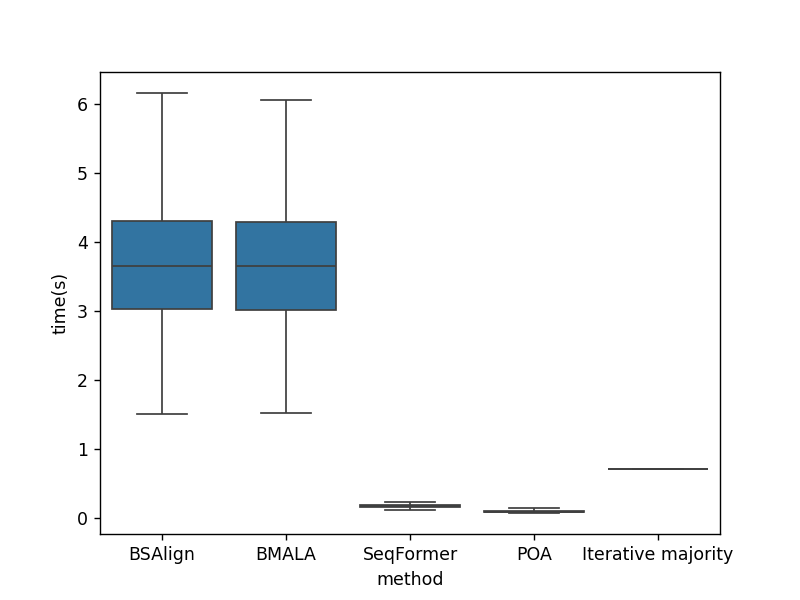

<Axes: xlabel='method', ylabel='time(s)'>

In [17]:
plt.figure()
sns.boxplot(data=runtime_df, x='method', y='time(s)', showfliers=False)

In [18]:
stat_df

,method,dis,depth,cluster
0,SeqFormer,0,5,0
1,POA,0,5,0
2,BSAlign,0,5,0
3,BMALA,0,5,0
4,Iterative majority,0,5,0
...,...,...,...,...
253045,SeqFormer,0,25,2409
253046,POA,0,25,2409
253047,BSAlign,0,25,2409
253048,BMALA,0,25,2409


In [19]:
result_df = (
    stat_df.groupby(['method', 'depth'])
      .agg(
          cluster_count=('cluster', 'nunique'),           # unique clusters
          zero_distance_count=('dis', lambda x: (x == 0).sum()),  # count of zero distance
          sum_distance=('dis', 'sum')                    # sum of distances
      )
      .reset_index()
)
result_df['success_rate'] = result_df['zero_distance_count'] / result_df['cluster_count']
result_df['mean_distance'] = result_df['sum_distance'] / result_df['cluster_count']

In [20]:
result_df

,method,depth,cluster_count,zero_distance_count,sum_distance,success_rate,mean_distance
0,BMALA,5,2410,2390,47,0.991701,0.019502
1,BMALA,6,2410,2395,36,0.993776,0.014938
2,BMALA,7,2410,2404,14,0.997510,0.005809
3,BMALA,8,2410,2406,6,0.998340,0.002490
4,BMALA,9,2410,2407,3,0.998755,0.001245
...,...,...,...,...,...,...,...
100,SeqFormer,21,2410,2409,1,0.999585,0.000415
101,SeqFormer,22,2410,2410,0,1.000000,0.000000
102,SeqFormer,23,2410,2410,0,1.000000,0.000000
103,SeqFormer,24,2410,2410,0,1.000000,0.000000


In [21]:
result_df[['method', 'depth', 'mean_distance', 'success_rate']].to_csv('bench_result_illumina_v2_second.csv', sep=',', index=False)

In [22]:
result_df.groupby(['method']).agg(mean_success=('success_rate', 'mean')).reset_index()

,method,mean_success
0,BMALA,0.998755
1,BSAlign,0.998498
2,Iterative majority,0.999131
3,POA,0.998656
4,SeqFormer,0.999289


<IPython.core.display.Javascript object>


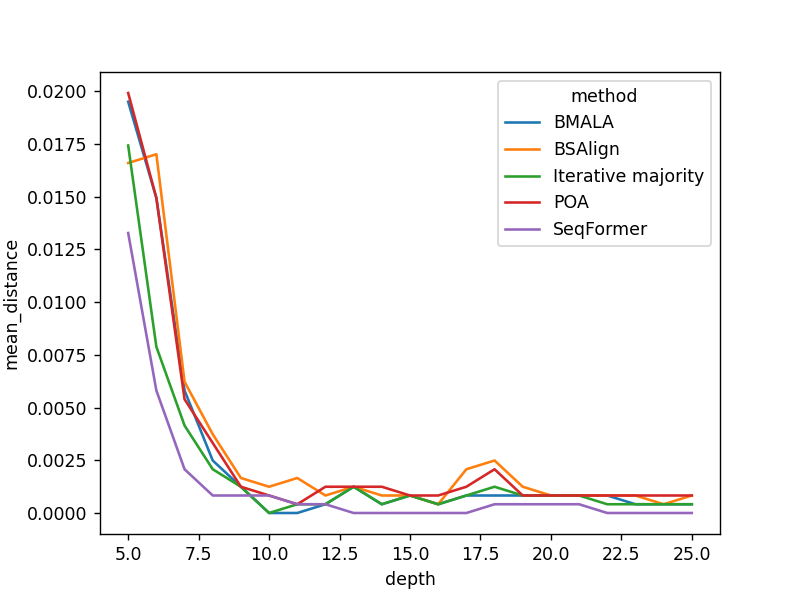

<Axes: xlabel='depth', ylabel='mean_distance'>

In [23]:
plt.figure()
sns.lineplot(data=result_df, x='depth', y='mean_distance', hue='method')

<IPython.core.display.Javascript object>


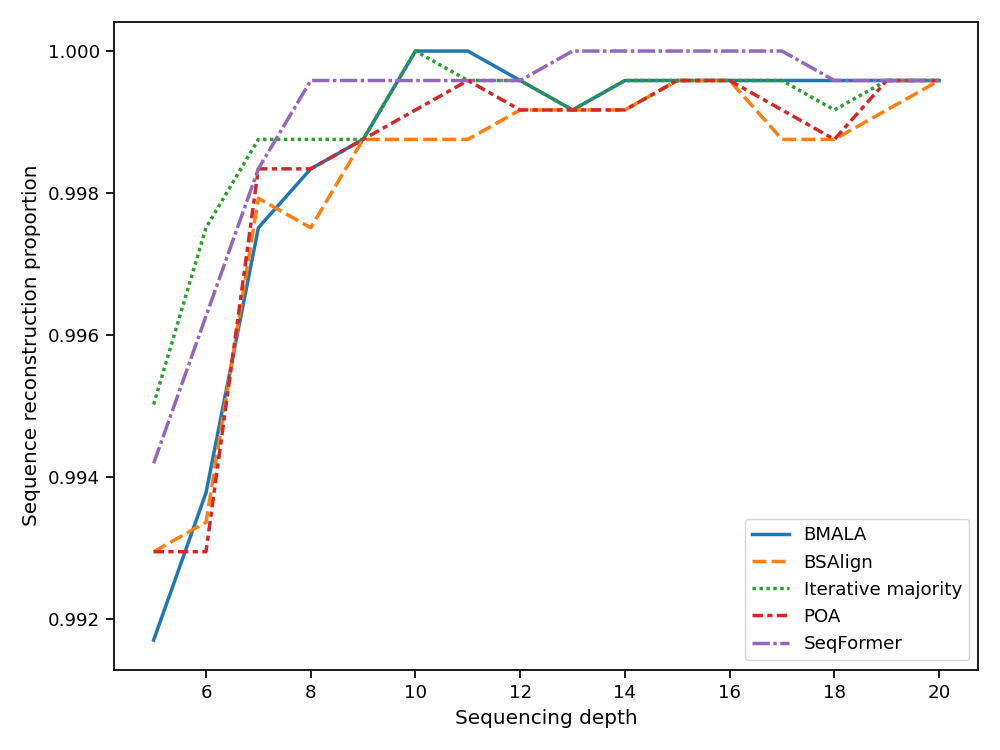

In [24]:
plt.figure(figsize=(8, 6))
sns.set_context("paper", font_scale=1.2)
sns.lineplot(data=result_df[result_df['depth'] <= 20], x='depth', y='success_rate', hue='method', style="method", lw=2)
plt.legend(loc='best',)
plt.xlabel('Sequencing depth')
plt.ylabel('Sequence reconstruction proportion')
plt.tight_layout()
plt.savefig('illumina_reco_bench_v2_second.png', dpi=400)

In [25]:
with open("model_bench_illumina_v2_all_second.pkl", "wb") as f:
    pickle.dump(ont_ret_dict, f)